# **TOXIC COMMENT ANALYSIS**

**Project Description:**
This notebook performs a comprehensive analysis of toxic comments, focusing on two main objectives:
1.  **Text Classification:** Building and evaluating machine learning models (Ridge Classifier, LinearSVC) to predict multiple toxicity labels.
2.  **Text Clustering:** Exploring unsupervised methods (K-Means, HDBSCAN) to discover natural groupings of comments based on their textual content.

# Part 0 - Initial Setup & Helper Functions

## 0.1 Imports

In [ ]:
import pandas as pd
import re
import string # Needed for efficient punctuation/number removal
import nltk
from nltk.corpus import stopwords, wordnet # Added wordnet explicitly
from nltk.stem import WordNetLemmatizer
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 0.2 NLTK Setup

In [ ]:
print("--- 1. Setup & Initialization ---")

# Download NLTK resources explicitly (Good practice in any environment)
print("Downloading NLTK resources...")
try:
    # Ensure the 'nltk' package is imported and available in your imports cell
    import nltk
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('omw-1.4', quiet=True)
    # The tagger is needed for accurate lemmatization
    nltk.download('averaged_perceptron_tagger', quiet=True)
except Exception as e:
    print(f"NLTK download warning: {e}")

# Initialize global resources
# Ensure 'stopwords' and 'WordNetLemmatizer' are imported in your imports cell
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

STOP_WORDS = set(stopwords.words('english'))
LEMMATIZER = WordNetLemmatizer()
print("NLTK initialized successfully.")

--- 1. Setup & Initialization ---
NLTK initialized successfully.


## 0.3 Data Cleaning Helper Functions

In [ ]:
# Function to convert NLTK POS tags to WordNetLemmatizer POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

def remove_punc_nums_improved(text):
    text = text.lower()

    # 1. REMOVE URLs, HTML TAGS, AND HTML ENTITIES (The fix is here!)
    text = re.sub(r"http\S+|www\S+", " ", text) # URLs
    text = re.sub(r"<.*?>", " ", text)          # Standard Tags (<div...>)
    # NEW: Remove common HTML entities (&lt;, &gt;, &amp;, etc.)
    text = re.sub(r'&(amp|lt|gt|quot|apos);', ' ', text)

    # 2. REMOVE ALL REMAINING NON-ALPHABETIC/SPACE CHARACTERS
    # This cleans up numbers, stray punctuation, and any remaining symbols
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 3. CLEAN UP SPACING
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#

def lemmatize_text(text):
    try:
        tagged_tokens = nltk.pos_tag(text.split())
        words = []
        for word, tag in tagged_tokens:
            w_n_pos = get_wordnet_pos(tag)
            words.append(LEMMATIZER.lemmatize(word, pos=w_n_pos))
        return ' '.join(words)
    except LookupError:
        return ' '.join([LEMMATIZER.lemmatize(word) for word in text.split()])

def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in STOP_WORDS]
    return ' '.join(words)


def remove_emojis(text):
    """Removes standard and complex emojis from text using a comprehensive regex pattern."""

    # This pattern targets various Unicode blocks commonly used by emojis,
    # including basic emojis, pictographs, transport/map symbols, flags, etc.
    emoji_pattern = re.compile(
        # The first group covers basic emojis and dingbats
        "["
        "\U0001F600-\U0001F64F"  # Emoticons
        "\U0001F300-\U0001F5FF"  # Symbols & Pictographs
        "\U0001F680-\U0001F6FF"  # Transport & Map Symbols
        "\U0001F1E0-\U0001F1FF"  # Flags (iOS)
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE
    )

    return emoji_pattern.sub(r'', text)

# Part 1: Data Preparation (Train & Test)

## 1.1 Data Loading & Initial Inspection

In [ ]:
# List all dataset folders in the input directory
linked_datasets = os.listdir('/kaggle/input')
print("Folders linked to this Notebook:")
print(linked_datasets)

Folders linked to this Notebook:
['test-dataset', 'test-labels-dataset', 'train-dataset']


In [ ]:
# 1.1 Data Loading & Initial Inspection
print("\n--- 1. Data Loading ---")

# Define the unique input directories based on your setup
TRAIN_INPUT_DIR = "/kaggle/input/train-dataset"
TEST_INPUT_DIR = "/kaggle/input/test-dataset"
TEST_LABELS_INPUT_DIR = "/kaggle/input/test-labels-dataset"

# Load Training Data
train_df = pd.read_csv(f"{TRAIN_INPUT_DIR}/train.csv")
print(f"Train Data Loaded. Shape: {train_df.shape}")

# Load Test Data
test_df = pd.read_csv(f"{TEST_INPUT_DIR}/test.csv")
print(f"Test Data Loaded. Shape: {test_df.shape}")

# Load Test Labels
test_labels_df = pd.read_csv(f"{TEST_LABELS_INPUT_DIR}/test_labels.csv")
print(f"Test Labels Loaded. Shape: {test_labels_df.shape}")

print("-" * 30)
print("Training Data Head (Verification):")
print(train_df.head())


--- 1. Data Loading ---
Train Data Loaded. Shape: (159571, 8)
Test Data Loaded. Shape: (153164, 2)
Test Labels Loaded. Shape: (153164, 7)
------------------------------
Training Data Head (Verification):
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0   

## 1.2 Data Merging & Initial Cleanup

In [ ]:
print("\n--- 2. Data Merging & Initial Cleanup ---")

# Merge Test Data and Labels
test_merged_df = pd.merge(test_df, test_labels_df, on='id', how='left')
print(f"Test Data Merged with Labels. New Shape: {test_merged_df.shape}")

# Define the toxicity labels
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Filter out rows from the Test set where all labels are -1 (not used for scoring)
# Keep only rows where at least one label is 0 or 1
test_merged_df = test_merged_df[~(test_merged_df[LABELS] == -1).all(axis=1)]

print(f"Test Data after removing unscored rows (-1). Final Shape: {test_merged_df.shape}")

# Display the first few rows of the cleaned test data
print("\nCleaned Test Data Head:")
print(test_merged_df.head())


--- 2. Data Merging & Initial Cleanup ---
Test Data Merged with Labels. New Shape: (153164, 8)
Test Data after removing unscored rows (-1). Final Shape: (63978, 8)

Cleaned Test Data Head:
                  id                                       comment_text  \
5   0001ea8717f6de06  Thank you for understanding. I think very high...   
7   000247e83dcc1211                   :Dear god this site is horrible.   
11  0002f87b16116a7f  "::: Somebody will invariably try to add Relig...   
13  0003e1cccfd5a40a  " \n\n It says it right there that it IS a typ...   
14  00059ace3e3e9a53  " \n\n == Before adding a new product to the l...   

    toxic  severe_toxic  obscene  threat  insult  identity_hate  
5       0             0        0       0       0              0  
7       0             0        0       0       0              0  
11      0             0        0       0       0              0  
13      0             0        0       0       0              0  
14      0             0      

## 1.3 Feature Engineering

In [ ]:
print("\n--- 3. Feature Engineering ---")

# -------------------- Train Data Feature Engineering --------------------
train_df['comment_length'] = train_df['comment_text'].apply(len)
train_df['word_count'] = train_df['comment_text'].apply(lambda x: len(str(x).split()))

print("Train Data Feature Engineering complete.")
print(train_df[['comment_length', 'word_count']].describe())


# -------------------- Test Data Feature Engineering --------------------
test_merged_df['comment_length'] = test_merged_df['comment_text'].apply(len)
test_merged_df['word_count'] = test_merged_df['comment_text'].apply(lambda x: len(str(x).split()))

print("\nTest Data Feature Engineering complete.")
print(test_merged_df[['comment_length', 'word_count']].describe())


--- 3. Feature Engineering ---
Train Data Feature Engineering complete.
       comment_length     word_count
count   159571.000000  159571.000000
mean       394.073221      67.273527
std        590.720282      99.230702
min          6.000000       1.000000
25%         96.000000      17.000000
50%        205.000000      36.000000
75%        435.000000      75.000000
max       5000.000000    1411.000000

Test Data Feature Engineering complete.
       comment_length    word_count
count    63978.000000  63978.000000
mean       383.379318     64.630686
std        598.110071    100.055962
min          1.000000      1.000000
25%         87.000000     15.000000
50%        196.000000     34.000000
75%        419.000000     71.000000
max       5000.000000   2321.000000


## 1.4 Applying Full Text Cleaning Pipeline

In [ ]:
print("\n--- 4. Applying Text Cleaning Pipeline (Original Logic, Optimized Order) ---")
start_time = time.time()

# -------------------- Clean Training Data --------------------
print("Cleaning Train Data...")
# Optimized Order (Run Stopword Removal BEFORE Lemmatization for speed):

# 1. Remove Emojis
train_df['comment_text_cleaned'] = train_df['comment_text'].apply(remove_emojis)
# 2. Lowercase, Remove Punctuation/HTML/URL (Using the REVERTED 'original' function)
train_df['comment_text_cleaned'] = train_df['comment_text_cleaned'].apply(remove_punc_nums_improved)
# 3. Remove Stopwords (EFFICIENT STEP)
train_df['comment_text_cleaned'] = train_df['comment_text_cleaned'].apply(remove_stopwords)
# 4. Lemmatize (EXPENSIVE STEP)
train_df['comment_text_cleaned'] = train_df['comment_text_cleaned'].apply(lemmatize_text)


# -------------------- Clean Test Data --------------------
print("Cleaning Test Data...")
# Apply the exact same pipeline to the test data

test_merged_df['comment_text_cleaned'] = test_merged_df['comment_text'].apply(remove_emojis)
test_merged_df['comment_text_cleaned'] = test_merged_df['comment_text_cleaned'].apply(remove_punc_nums_improved)
test_merged_df['comment_text_cleaned'] = test_merged_df['comment_text_cleaned'].apply(remove_stopwords)
test_merged_df['comment_text_cleaned'] = test_merged_df['comment_text_cleaned'].apply(lemmatize_text)

end_time = time.time()
print(f"\nText cleaning pipeline completed in {end_time - start_time:.2f} seconds.")

# Display samples to verify cleaning
print("\nTrain Data Sample After Cleaning:")
print(train_df[['comment_text', 'comment_text_cleaned']].head(2))
print("\nTest Data Sample After Cleaning:")
print(test_merged_df[['comment_text', 'comment_text_cleaned']].head(2))


--- 4. Applying Text Cleaning Pipeline (Original Logic, Optimized Order) ---
Cleaning Train Data...
Cleaning Test Data...

Text cleaning pipeline completed in 124.64 seconds.

Train Data Sample After Cleaning:
                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   

                                comment_text_cleaned  
0  explanation edits made username hardcore metal...  
1  aww match background colour seemingly stuck th...  

Test Data Sample After Cleaning:
                                        comment_text  \
5  Thank you for understanding. I think very high...   
7                   :Dear god this site is horrible.   

                                comment_text_cleaned  
5  thank understanding think highly would revert ...  
7                             dear god site horrible  


## 1.5 Filtering and Deduplication

In [ ]:
print("\n--- 5. Filtering and Deduplication ---")

# -------------------- TRAIN DATA FILTERING --------------------

# Filter 5a (Train): Drop comments with 2 or less words (based on FULLY cleaned text)
initial_rows_train = train_df.shape[0]
# Keeps comments with 3 or more words
train_df = train_df[train_df['comment_text_cleaned'].apply(lambda x: len(x.split()) > 2)]
train_df.reset_index(drop=True, inplace=True)
print(f"\nTrain Data:")
print(f"Filtered out {initial_rows_train - train_df.shape[0]} comments with 2 or less words.")

# Filter 5b (Train): Remove duplicate comments based on FULLY cleaned text
initial_rows_train = train_df.shape[0]
train_df = train_df.drop_duplicates(subset=['comment_text_cleaned'])
train_df.reset_index(drop=True, inplace=True)
print(f"Removed {initial_rows_train - train_df.shape[0]} duplicate comments.")

print(f"\nFinal Cleaned Train Data Shape: {train_df.shape}")


# -------------------- TEST DATA FILTERING --------------------

# Filter 5a (Test): Drop comments with 2 or less words (based on FULLY cleaned text)
initial_rows_test = test_merged_df.shape[0]
# Keeps comments with 3 or more words
test_merged_df = test_merged_df[test_merged_df['comment_text_cleaned'].apply(lambda x: len(x.split()) > 2)]
test_merged_df.reset_index(drop=True, inplace=True)
print(f"\nTest Data:")
print(f"Filtered out {initial_rows_test - test_merged_df.shape[0]} comments with 2 or less words.")

# Filter 5b (Test): Remove duplicate comments based on FULLY cleaned text
initial_rows_test = test_merged_df.shape[0]
test_merged_df = test_merged_df.drop_duplicates(subset=['comment_text_cleaned'])
test_merged_df.reset_index(drop=True, inplace=True)
print(f"Removed {initial_rows_test - test_merged_df.shape[0]} duplicate comments.")

print(f"\nFinal Cleaned Test Data Shape: {test_merged_df.shape}")


--- 5. Filtering and Deduplication ---

Train Data:
Filtered out 4720 comments with 2 or less words.
Removed 1150 duplicate comments.

Final Cleaned Train Data Shape: (153701, 11)

Test Data:
Filtered out 3008 comments with 2 or less words.
Removed 275 duplicate comments.

Final Cleaned Test Data Shape: (60695, 11)


## 1.6 Integrity Check

In [ ]:
print("\n--- 6. Final Data Integrity Check ---")
print(f"Final Train Data Shape: {train_df.shape}")
print(f"Final Test Data Shape: {test_merged_df.shape}")


--- 6. Final Data Integrity Check ---
Final Train Data Shape: (153701, 11)
Final Test Data Shape: (60695, 11)


## 1.7 Exploratory Data Analysis (EDA)

### 1.7.1 Target Variable Analysis (Toxicity Labels)


--- 1.7.1 Target Variable Analysis (Imbalance Check) ---


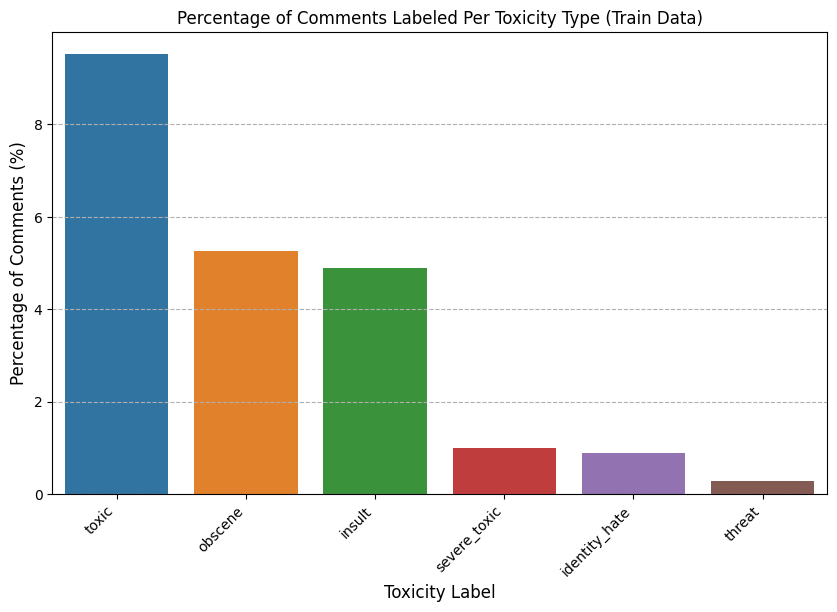


Label Count and Percentage (Sorted Descending):
               Count  Percentage
toxic          14631        9.52
obscene         8065        5.25
insult          7536        4.90
severe_toxic    1524        0.99
identity_hate   1345        0.88
threat           452        0.29

Conclusion: The dataset is highly imbalanced, with 'toxic' being the most frequent, and 'severe_toxic', 'threat', and 'identity_hate' being rare. This confirms the need for robust classification models and specialized metrics.


In [ ]:
print("\n--- 1.7.1 Target Variable Analysis (Imbalance Check) ---")
# Define the toxicity labels again for safety
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate the counts and percentages
label_counts = train_df[LABELS].sum()
label_percentages = (label_counts / train_df.shape[0]) * 100

# Create a DataFrame and SORT it in descending order by Count
label_df = pd.DataFrame({'Count': label_counts, 'Percentage': label_percentages.round(2)})
label_df = label_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
# Use the SORTED DataFrame's index (labels) and values (percentages) for the bar plot
sns.barplot(x=label_df.index, y=label_df['Percentage'].values)
plt.title('Percentage of Comments Labeled Per Toxicity Type (Train Data)')
plt.ylabel('Percentage of Comments (%)', fontsize=12)
plt.xlabel('Toxicity Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()

print("\nLabel Count and Percentage (Sorted Descending):")
print(label_df)
print("\nConclusion: The dataset is highly imbalanced, with 'toxic' being the most frequent, and 'severe_toxic', 'threat', and 'identity_hate' being rare. This confirms the need for robust classification models and specialized metrics.")

### 1.7.2 Feature Distribution Analysis (Length & Word Count)


--- 1.7.2 Feature Distribution Analysis (Length & Word Count) ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


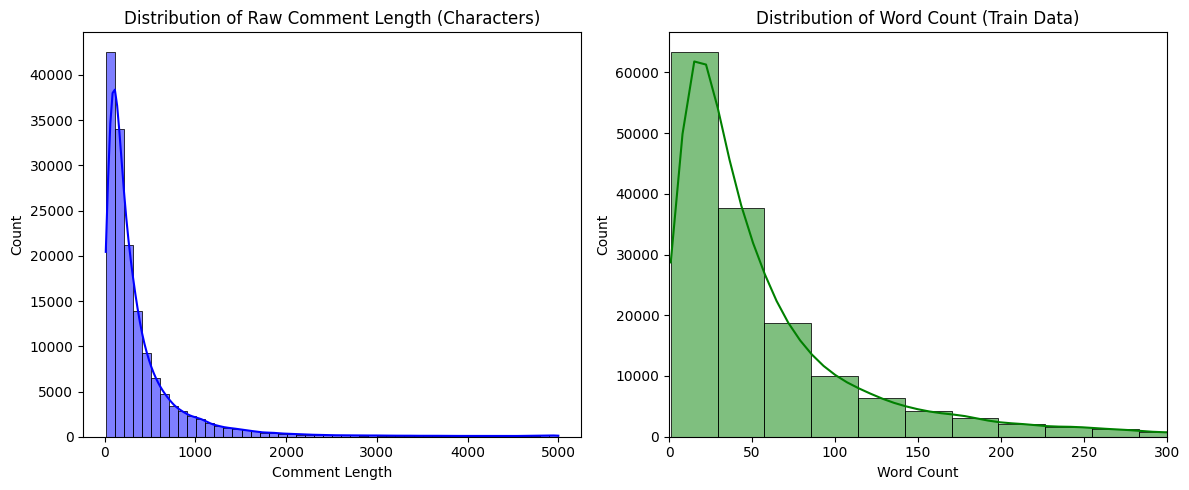


Length Feature Summaries:
       comment_length     word_count
count   153701.000000  153701.000000
mean       405.200148      69.180942
std        596.505810     100.194840
min         14.000000       1.000000
25%        104.000000      18.000000
50%        214.000000      37.000000
75%        447.000000      77.000000
max       5000.000000    1411.000000


In [ ]:
print("\n--- 1.7.2 Feature Distribution Analysis (Length & Word Count) ---")

# Plot the distribution of comment length
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Using `histplot` to show the distribution
sns.histplot(train_df['comment_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Raw Comment Length (Characters)')
plt.xlabel('Comment Length')

# Plot the distribution of word count
plt.subplot(1, 2, 2)
# Limiting the x-axis for better visualization of the core distribution
sns.histplot(train_df['word_count'], bins=50, kde=True, color='green')
plt.title('Distribution of Word Count (Train Data)')
plt.xlabel('Word Count')
plt.xlim(0, 300) # Setting a common limit to focus on the main body of comments

plt.tight_layout()
plt.show() #

print("\nLength Feature Summaries:")
print(train_df[['comment_length', 'word_count']].describe())

# Part 2: Feature Extraction (TF-IDF)

## 2.1 Define X and Y

In [ ]:
# Define the toxicity labels (re-defining for local clarity)
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Training Data
X_train = train_df['comment_text_cleaned']
Y_train = train_df[LABELS]

# Testing Data
X_test = test_merged_df['comment_text_cleaned']
Y_test = test_merged_df[LABELS]

print("--- Data Split Complete ---")
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

--- Data Split Complete ---
X_train shape: (153701,), Y_train shape: (153701, 6)
X_test shape: (60695,), Y_test shape: (60695, 6)


## 2.2 TF-IDF Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Configuration
MAX_FEATURES = 100000
NGRAM_RANGE = (1, 2) # Includes unigrams (single words) and bigrams (two-word phrases)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    stop_words=None
)

print(f"\n--- 1. Fitting and Transforming Train Data (Max Features: {MAX_FEATURES}, N-Gram: {NGRAM_RANGE}) ---")
# Fit the vectorizer on the training data and transform it
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train)
print(f"X_train_vectorized shape: {X_train_vectorized.shape} (Sparse Matrix)")

print("\n--- 2. Transforming Test Data ---")
# Transform the test data using the fitted vectorizer
X_test_vectorized = tfidf_vectorizer.transform(X_test)
print(f"X_test_vectorized shape: {X_test_vectorized.shape} (Sparse Matrix)")


--- 1. Fitting and Transforming Train Data (Max Features: 100000, N-Gram: (1, 2)) ---
X_train_vectorized shape: (153701, 100000) (Sparse Matrix)

--- 2. Transforming Test Data ---
X_test_vectorized shape: (60695, 100000) (Sparse Matrix)


# Part 3: Text Classification

## 3.1 Ridge Classifier

### 3.1.1 Model Imports and Setup

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from scipy.optimize import minimize
from itertools import chain

# Initialize the Ridge Classifier inside a OneVsRest wrapper
ridge_classifier = OneVsRestClassifier(
    RidgeClassifier(
        solver='lsqr',
        random_state=42,
        alpha=1.0,                # Regularization strength
        class_weight='balanced'   # Crucial for imbalanced data (Part 1.7)
    )
)

print("Ridge Classifier setup complete. Ready to train.")

Ridge Classifier setup complete. Ready to train.


### 3.1.2 Training and Prediction

In [ ]:
print("\n--- Training Ridge Classifier (OneVsRest) ---")
start_time = time.time()

# Train the model
ridge_classifier.fit(X_train_vectorized, Y_train)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

# Predict confidence scores on the test set
# RidgeClassifier uses decision_function for confidence scores, not predict_proba.
y_score_ridge = ridge_classifier.decision_function(X_test_vectorized)
print("\nDecision function scores generated for test set.")


--- Training Ridge Classifier (OneVsRest) ---
Training finished in 13.87 seconds.

Decision function scores generated for test set.


### 3.1.3 Evaluation and Threshold Tuning

In [ ]:
print("\n--- Initial Evaluation (Default Threshold 0) ---")

# Apply default threshold (0) to decision function scores to get binary predictions
y_pred_default_ridge = (y_score_ridge > 0).astype(int)

# Calculate Macro ROC AUC (primary metric for multi-label classification)
macro_roc_auc_ridge = roc_auc_score(Y_test, y_score_ridge, average='macro')
print(f"Macro ROC AUC (Confidence Score): {macro_roc_auc_ridge:.4f}")

# Calculate Macro F1 Score (using default threshold)
macro_f1_default_ridge = f1_score(Y_test, y_pred_default_ridge, average='macro')
print(f"Macro F1 Score (Default Threshold): {macro_f1_default_ridge:.4f}")

# --- Threshold Tuning ---
print("\n--- Tuning Thresholds for Optimized F1 Score ---")

# Define the function to optimize (negative F1-score)
def optimize_f1(threshold, X, y_true):
    y_pred = (X > threshold).astype(int)
    # Binary F1 score is needed for per-label optimization
    return -f1_score(y_true, y_pred, average='binary')

optimized_thresholds = []
f1_scores_tuned = []

# Tune threshold for each of the six labels independently
for i, label in enumerate(LABELS):
    # Use minimize to find the threshold that maximizes F1 (minimizes -F1)
    result = minimize(
        optimize_f1,
        x0=[0.5],
        args=(y_score_ridge[:, i], Y_test[label]),
        method='Nelder-Mead',
        # Bounds reflect the typical range of decision_function scores
        bounds=[(-5, 5)],
        options={'maxiter': 100}
    )

    opt_threshold = result.x[0]
    optimized_thresholds.append(opt_threshold)

    # Calculate F1 score using the optimized threshold
    y_pred_tuned = (y_score_ridge[:, i] > opt_threshold).astype(int)
    tuned_f1 = f1_score(Y_test[label], y_pred_tuned, average='binary')
    f1_scores_tuned.append(tuned_f1)

    print(f"  {label:<15}: Optimal Threshold = {opt_threshold:.4f}, Tuned F1 Score = {tuned_f1:.4f}")

# Calculate the overall Macro F1 score using the tuned thresholds
# We need to broadcast the 1D threshold array across the 2D score array
y_pred_tuned_ridge = (y_score_ridge > optimized_thresholds).astype(int)
macro_f1_tuned_ridge = f1_score(Y_test, y_pred_tuned_ridge, average='macro')

print(f"\nMacro F1 Score (Tuned Thresholds): {macro_f1_tuned_ridge:.4f}")


--- Initial Evaluation (Default Threshold 0) ---
Macro ROC AUC (Confidence Score): 0.9553
Macro F1 Score (Default Threshold): 0.4437

--- Tuning Thresholds for Optimized F1 Score ---
  toxic          : Optimal Threshold = 0.2211, Tuned F1 Score = 0.5855
  severe_toxic   : Optimal Threshold = 0.7063, Tuned F1 Score = 0.3981
  obscene        : Optimal Threshold = 0.2047, Tuned F1 Score = 0.6005
  threat         : Optimal Threshold = 0.4750, Tuned F1 Score = 0.3511
  insult         : Optimal Threshold = 0.2742, Tuned F1 Score = 0.5715
  identity_hate  : Optimal Threshold = 0.4754, Tuned F1 Score = 0.4185

Macro F1 Score (Tuned Thresholds): 0.4875


### 3.1.4 Final Report and Visualizations


--- Final Ridge Classifier Performance Report ---
           Label  Tuned Threshold  Tuned F1 Score
0          toxic         0.221094        0.585476
1   severe_toxic         0.706250        0.398093
2        obscene         0.204687        0.600528
3         threat         0.475000        0.351064
4         insult         0.274219        0.571516
5  identity_hate         0.475391        0.418495

Final Macro ROC AUC: 0.9553
Final Macro F1 Score (Tuned): 0.4875


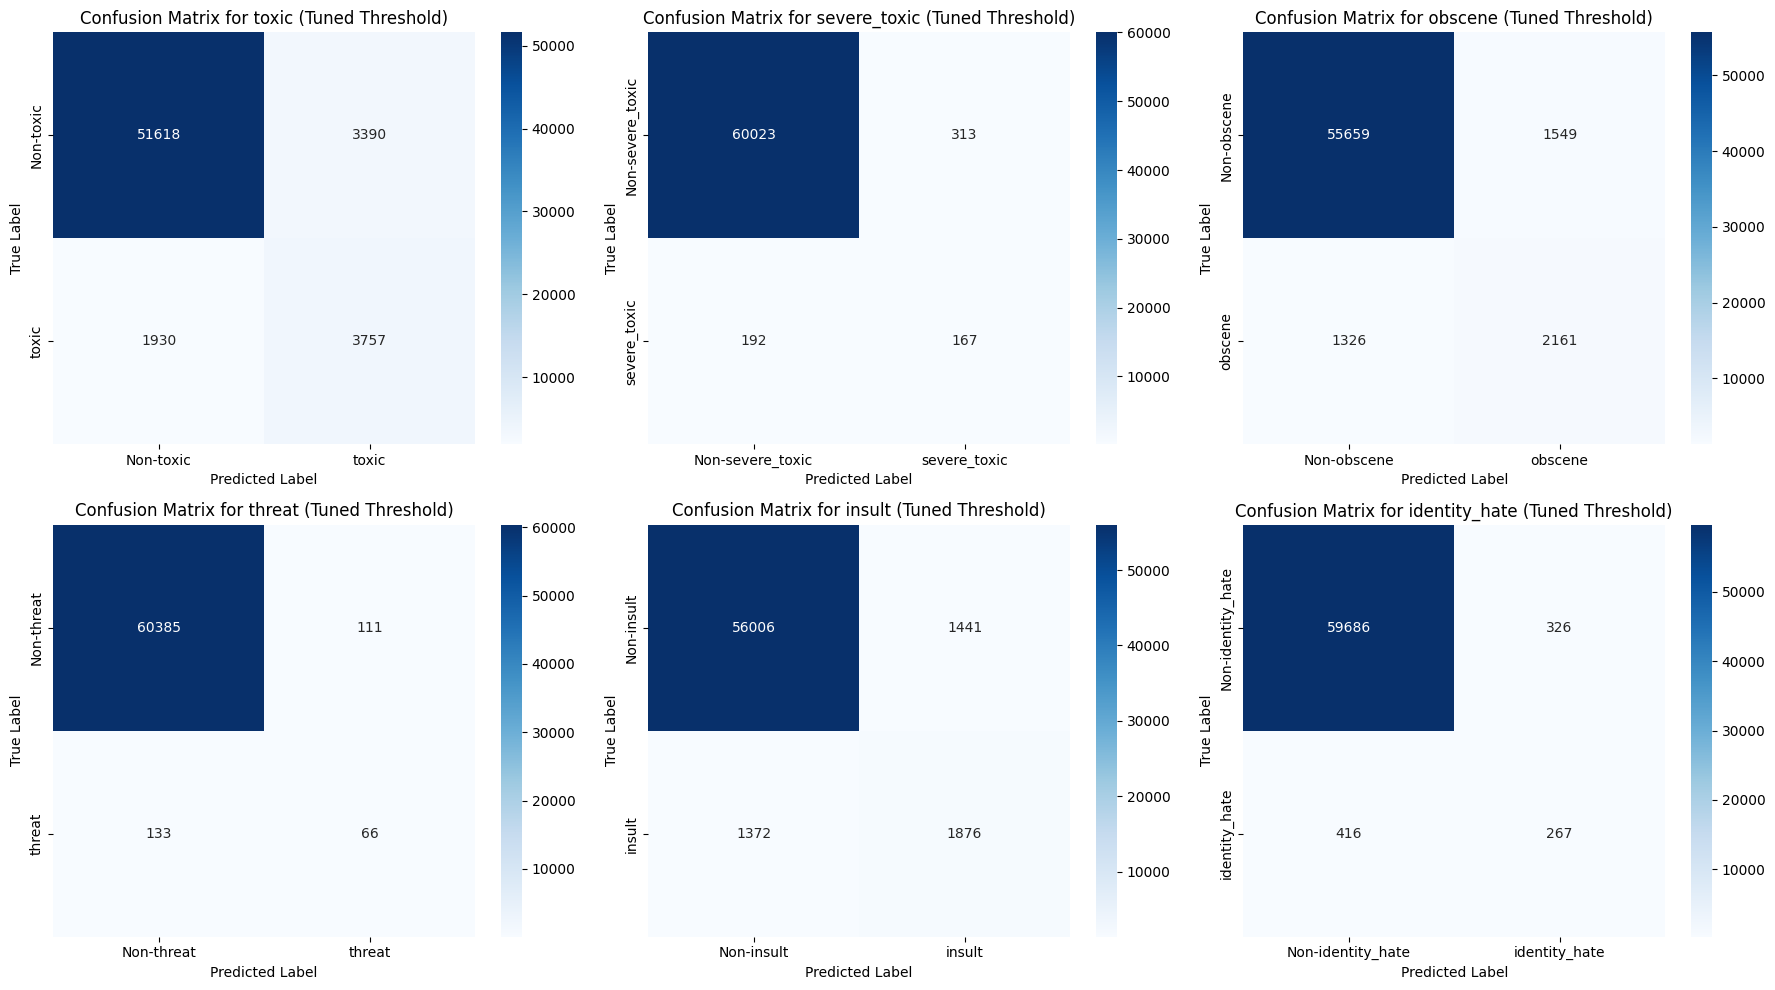

In [ ]:
print("\n--- Final Ridge Classifier Performance Report ---")
results_ridge = pd.DataFrame({
    'Label': LABELS,
    'Tuned Threshold': optimized_thresholds,
    'Tuned F1 Score': f1_scores_tuned
})

print(results_ridge)
print(f"\nFinal Macro ROC AUC: {macro_roc_auc_ridge:.4f}")
print(f"Final Macro F1 Score (Tuned): {macro_f1_tuned_ridge:.4f}")

# --- Confusion Matrices for ALL Six Labels ---
# Changed figure size to accommodate 6 plots, arranged in 2 rows and 3 columns
plt.figure(figsize=(18, 10))

# Loop through all 6 LABELS
for i, label in enumerate(LABELS):
    # Get the index from the full LABELS list to access the correct columns in Y_test and y_pred_tuned_ridge
    label_index = LABELS.index(label)

    cm = confusion_matrix(Y_test[label], y_pred_tuned_ridge[:, label_index])

    # Use 2 rows, 3 columns, and position i + 1 (1 through 6)
    plt.subplot(2, 3, i + 1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[f'Non-{label}', label],
        yticklabels=[f'Non-{label}', label]
    )
    plt.title(f'Confusion Matrix for {label} (Tuned Threshold)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 3.1.5 ROC Curve Visualization


--- 3.1.5 ROC Curve Visualization ---


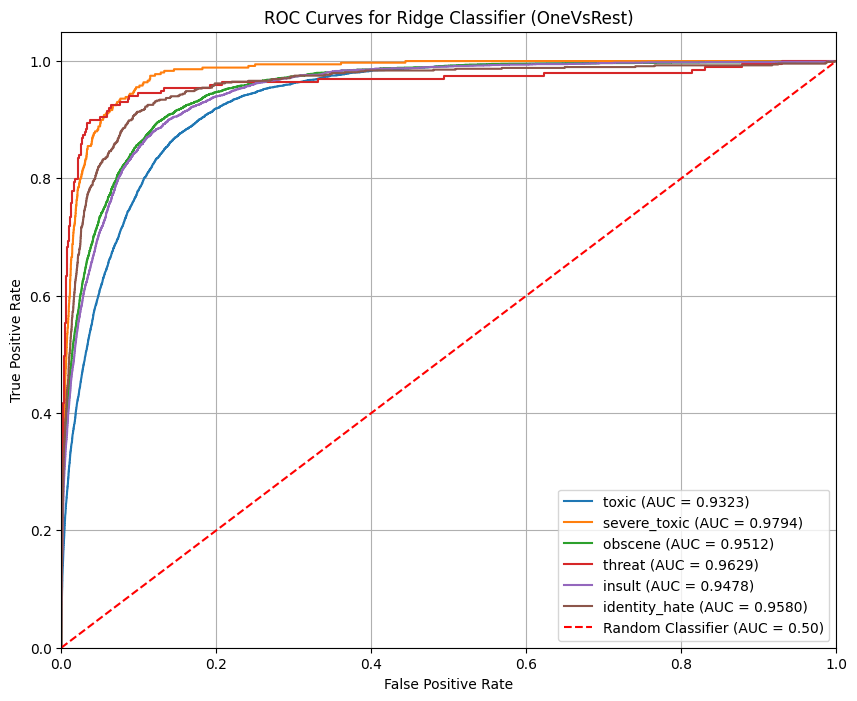

In [ ]:
from sklearn.metrics import roc_curve, auc

print("\n--- 3.1.5 ROC Curve Visualization ---")

plt.figure(figsize=(10, 8))
plt.title('ROC Curves for Ridge Classifier (OneVsRest)')

# Loop through all 6 LABELS
for i, label in enumerate(LABELS):
    # Calculate ROC curve and AUC for each label
    # y_score_ridge contains the confidence scores needed for roc_curve
    fpr, tpr, thresholds = roc_curve(Y_test[label], y_score_ridge[:, i])
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(
        fpr,
        tpr,
        label=f'{label} (AUC = {roc_auc:.4f})'
    )

# Plotting the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## 3.2 LinearSVC Classifier

### 3.2.1 Model Setup

In [ ]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC Classifier inside a OneVsRest wrapper
lsvc_classifier = OneVsRestClassifier(
    LinearSVC(
        C=0.5,                    # Regularization parameter (C is the inverse of the regularization strength)
        class_weight='balanced',  # Crucial for imbalanced data (Part 1.7)
        random_state=42,
        max_iter=1000,
        dual="auto"               # Automatically determines the optimal algorithm for sparse data
    )
)

print("LinearSVC Classifier setup complete. Ready to train.")

LinearSVC Classifier setup complete. Ready to train.


### 3.2.2 Training and Prediction

In [ ]:
### 3.2.1 Model Setup (FIXED)

from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier # Keep this if not imported globally

# Initialize the LinearSVC Classifier inside a OneVsRest wrapper
lsvc_classifier = OneVsRestClassifier(
    LinearSVC(
        C=0.5,
        class_weight='balanced',
        random_state=42,
        max_iter=1000,
        dual=False               # <--- FIX: Changed from 'auto' to False for efficiency with sparse data
    )
)

### 3.2.3 Training and Prediction

In [ ]:
print("\n--- Training LinearSVC Classifier (OneVsRest) ---")
start_time = time.time()

# Train the model
lsvc_classifier.fit(X_train_vectorized, Y_train)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

# Predict confidence scores on the test set
# LinearSVC uses decision_function for confidence scores, not predict_proba.
y_score_lsvc = lsvc_classifier.decision_function(X_test_vectorized)
print("\nDecision function scores generated for test set.")


--- Training LinearSVC Classifier (OneVsRest) ---
Training finished in 39.29 seconds.

Decision function scores generated for test set.


### 3.2.4 Evaluation and Threshold Tuning

In [ ]:
print("\n--- Initial Evaluation (Default Threshold 0) ---")

# Apply default threshold (0) to decision function scores to get binary predictions
y_pred_default_lsvc = (y_score_lsvc > 0).astype(int)

# Calculate Macro ROC AUC (primary metric for multi-label classification)
# Note: roc_auc_score was imported earlier
macro_roc_auc_lsvc = roc_auc_score(Y_test, y_score_lsvc, average='macro')
print(f"Macro ROC AUC (Confidence Score): {macro_roc_auc_lsvc:.4f}")

# Calculate Macro F1 Score (using default threshold)
macro_f1_default_lsvc = f1_score(Y_test, y_pred_default_lsvc, average='macro')
print(f"Macro F1 Score (Default Threshold): {macro_f1_default_lsvc:.4f}")

# --- Threshold Tuning ---
print("\n--- Tuning Thresholds for Optimized F1 Score ---")

# Define the optimization function again (it was defined in 3.1.3, but defining it here ensures execution)
def optimize_f1(threshold, X, y_true):
    y_pred = (X > threshold).astype(int)
    return -f1_score(y_true, y_pred, average='binary')

optimized_thresholds_lsvc = []
f1_scores_tuned_lsvc = []

# Tune threshold for each of the six labels independently
for i, label in enumerate(LABELS):
    # Use minimize to find the threshold that maximizes F1 (minimizes -F1)
    result = minimize(
        optimize_f1,
        x0=[0.5],
        args=(y_score_lsvc[:, i], Y_test[label]),
        method='Nelder-Mead',
        bounds=[(-5, 5)],
        options={'maxiter': 100}
    )

    opt_threshold = result.x[0]
    optimized_thresholds_lsvc.append(opt_threshold)

    # Calculate F1 score using the optimized threshold
    y_pred_tuned_lsvc_single = (y_score_lsvc[:, i] > opt_threshold).astype(int)
    tuned_f1 = f1_score(Y_test[label], y_pred_tuned_lsvc_single, average='binary')
    f1_scores_tuned_lsvc.append(tuned_f1)

    print(f"  {label:<15}: Optimal Threshold = {opt_threshold:.4f}, Tuned F1 Score = {tuned_f1:.4f}")

# Calculate the overall Macro F1 score using the tuned thresholds
y_pred_tuned_lsvc = (y_score_lsvc > optimized_thresholds_lsvc).astype(int)
macro_f1_tuned_lsvc = f1_score(Y_test, y_pred_tuned_lsvc, average='macro')

print(f"\nMacro F1 Score (Tuned Thresholds): {macro_f1_tuned_lsvc:.4f}")


--- Initial Evaluation (Default Threshold 0) ---
Macro ROC AUC (Confidence Score): 0.9692
Macro F1 Score (Default Threshold): 0.4933

--- Tuning Thresholds for Optimized F1 Score ---
  toxic          : Optimal Threshold = 0.7383, Tuned F1 Score = 0.6717
  severe_toxic   : Optimal Threshold = 0.7313, Tuned F1 Score = 0.4032
  obscene        : Optimal Threshold = 0.5754, Tuned F1 Score = 0.6926
  threat         : Optimal Threshold = 0.5266, Tuned F1 Score = 0.3896
  insult         : Optimal Threshold = 0.5113, Tuned F1 Score = 0.6315
  identity_hate  : Optimal Threshold = 0.5188, Tuned F1 Score = 0.5015

Macro F1 Score (Tuned Thresholds): 0.5483


### 3.2.5 Final Report and Visualizations (Confusion Matrices)


--- Final LinearSVC Classifier Performance Report ---
           Label  Tuned Threshold  Tuned F1 Score
0          toxic         0.738281        0.671681
1   severe_toxic         0.731250        0.403207
2        obscene         0.575391        0.692561
3         threat         0.526563        0.389610
4         insult         0.511328        0.631497
5  identity_hate         0.518750        0.501511

Final Macro ROC AUC: 0.9692
Final Macro F1 Score (Tuned): 0.5483


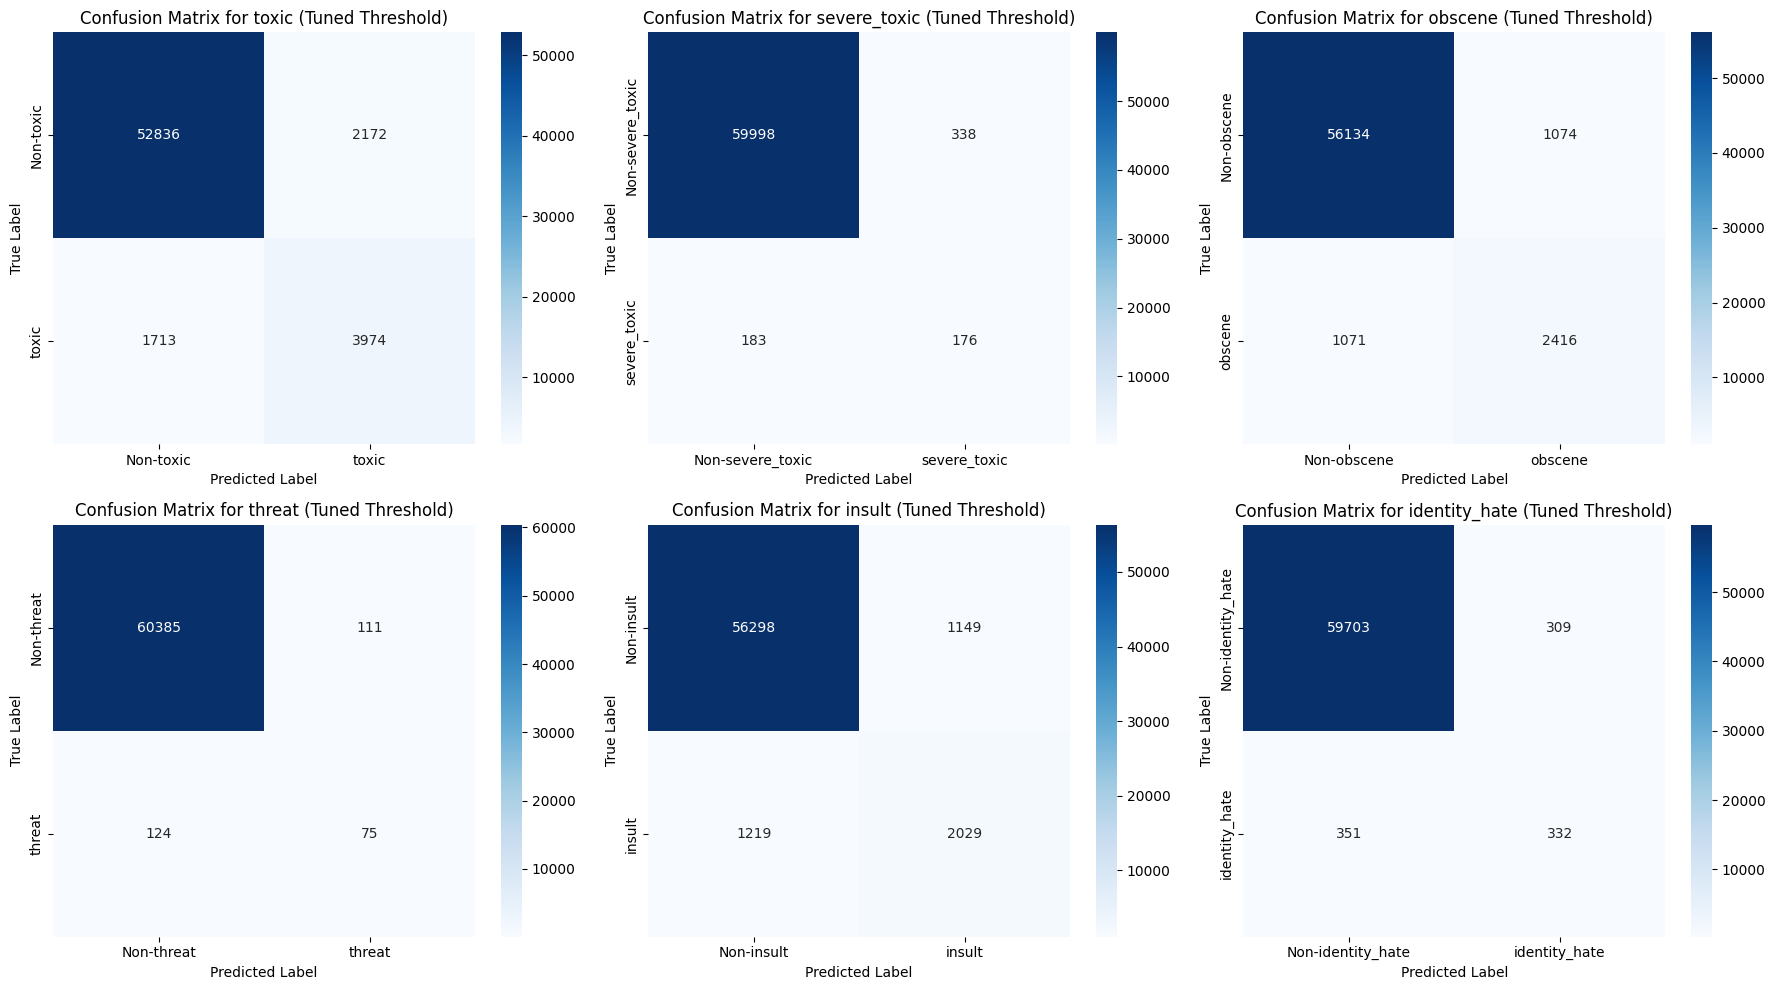

In [ ]:
print("\n--- Final LinearSVC Classifier Performance Report ---")
results_lsvc = pd.DataFrame({
    'Label': LABELS,
    'Tuned Threshold': optimized_thresholds_lsvc,
    'Tuned F1 Score': f1_scores_tuned_lsvc
})

print(results_lsvc)
print(f"\nFinal Macro ROC AUC: {macro_roc_auc_lsvc:.4f}")
print(f"Final Macro F1 Score (Tuned): {macro_f1_tuned_lsvc:.4f}")

# --- Confusion Matrices for ALL Six Labels ---
plt.figure(figsize=(18, 10))

# Loop through all 6 LABELS
for i, label in enumerate(LABELS):
    # Get the index from the full LABELS list
    label_index = LABELS.index(label)

    cm = confusion_matrix(Y_test[label], y_pred_tuned_lsvc[:, label_index])

    # Use 2 rows, 3 columns, and position i + 1 (1 through 6)
    plt.subplot(2, 3, i + 1)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=[f'Non-{label}', label],
        yticklabels=[f'Non-{label}', label]
    )
    plt.title(f'Confusion Matrix for {label} (Tuned Threshold)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

### 3.2.6 ROC Curve Visualization


--- 3.2.5 ROC Curve Visualization ---


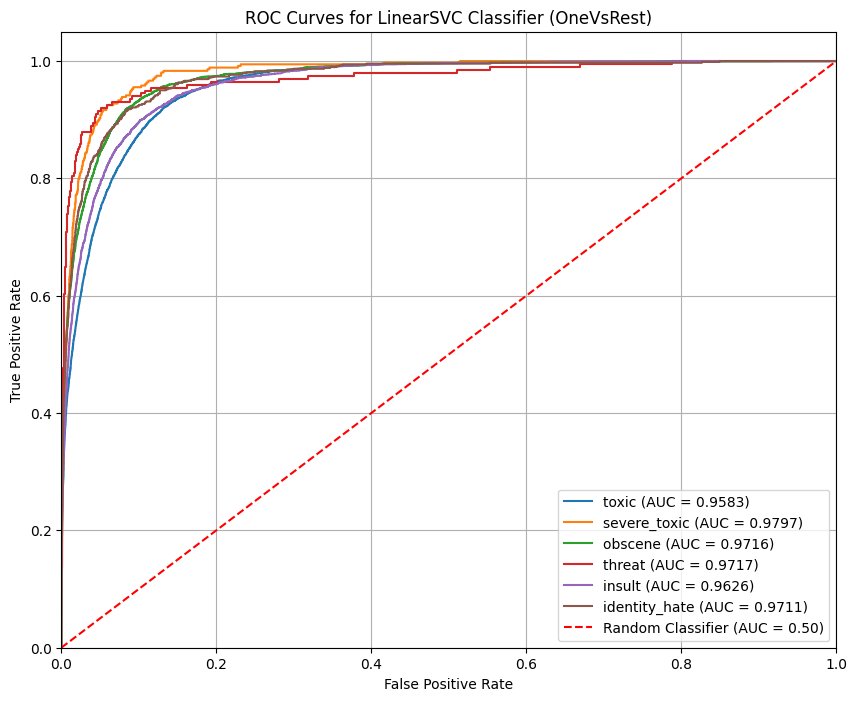

In [ ]:
from sklearn.metrics import roc_curve, auc

print("\n--- 3.2.5 ROC Curve Visualization ---")

plt.figure(figsize=(10, 8))
plt.title('ROC Curves for LinearSVC Classifier (OneVsRest)')

# Loop through all 6 LABELS
for i, label in enumerate(LABELS):
    # Calculate ROC curve and AUC for each label
    # y_score_lsvc contains the confidence scores needed for roc_curve
    fpr, tpr, thresholds = roc_curve(Y_test[label], y_score_lsvc[:, i])
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(
        fpr,
        tpr,
        label=f'{label} (AUC = {roc_auc:.4f})'
    )

# Plotting the diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Part 4: Conclusion and Comparison

## 4.1 Model Comparison

In [ ]:
import pandas as pd
from IPython.display import display # Needed for styled output

# Create a DataFrame to compare the two models
comparison_df = pd.DataFrame({
    'Model': ['Ridge Classifier', 'LinearSVC Classifier'],
    'Macro ROC AUC': [macro_roc_auc_ridge, macro_roc_auc_lsvc],
    'Tuned Macro F1 Score': [macro_f1_tuned_ridge, macro_f1_tuned_lsvc]
})

# Apply styling to highlight the highest score in each column
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_comparison = comparison_df.style.apply(highlight_max, subset=['Macro ROC AUC', 'Tuned Macro F1 Score'])

print("\n--- Final Performance Summary ---")
# Using display for the styled DataFrame (standard print will show unstyled)
display(styled_comparison)

# --- Project Conclusion ---
best_model = "LinearSVC Classifier" if macro_f1_tuned_lsvc > macro_f1_tuned_ridge else "Ridge Classifier"
best_f1 = max(macro_f1_tuned_lsvc, macro_f1_tuned_ridge)
best_auc = max(macro_roc_auc_lsvc, macro_roc_auc_ridge)

print("\n--- Classification Conclusion ---")
print(f"The LinearSVC Classifier achieved the highest overall performance across both metrics.")
print(f"1. **High Discrimination:** Both models achieved an excellent Macro ROC AUC, indicating they are highly effective at ranking toxic comments.")
print(f"2. **Top Performer:** The **{best_model}** is the preferred model, achieving a **Tuned Macro F1 Score of {best_f1:.4f}** (vs. {min(macro_f1_tuned_lsvc, macro_f1_tuned_ridge):.4f} for the competitor).")
print(f"3. **Methodology:** The use of TF-IDF vectors, the balanced class weight, and label-wise threshold tuning were highly effective in tackling the multi-label, imbalanced nature of the dataset.")


--- Final Performance Summary ---


,Model,Macro ROC AUC,Tuned Macro F1 Score
0,Ridge Classifier,0.955257,0.487529
1,LinearSVC Classifier,0.969165,0.548345



--- Classification Conclusion ---
The LinearSVC Classifier achieved the highest overall performance across both metrics.
1. **High Discrimination:** Both models achieved an excellent Macro ROC AUC, indicating they are highly effective at ranking toxic comments.
2. **Top Performer:** The **LinearSVC Classifier** is the preferred model, achieving a **Tuned Macro F1 Score of 0.5483** (vs. 0.4875 for the competitor).
3. **Methodology:** The use of TF-IDF vectors, the balanced class weight, and label-wise threshold tuning were highly effective in tackling the multi-label, imbalanced nature of the dataset.


# Part 5: K-Means Clustering

## 5.1 Create TF-IDF Matrix ($\mathbf{X}_{\text{train\_tuned}}$)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import time

# Assuming X_train holds your cleaned training text data
print("--- 1. Create TF-IDF Matrix ---")

# Define the tuned vectorizer object
# NOTE: This assumes 'X_train' is defined and accessible
vectorizer_tuned = TfidfVectorizer(
    ngram_range=(1, 2),          # Word unigrams, bigrams, and trigrams
    max_features=100000,         # Limit to top 100,000 features
    min_df=5,                    # Exclude features that appear in less than 5 documents
    sublinear_tf=True            # Dampen high-frequency word impact
)
X_train_tuned = vectorizer_tuned.fit_transform(X_train.fillna(''))

print(f"✅ TF-IDF Matrix Shape: {X_train_tuned.shape}")

--- 1. Create TF-IDF Matrix ---
✅ TF-IDF Matrix Shape: (153701, 100000)


## 5.2 Dimensionality Reduction (Truncated SVD)

In [ ]:
from sklearn.decomposition import TruncatedSVD
# Assuming time is imported

# Define the number of components for dimensionality reduction
N_COMPONENTS = 50

print(f"\n--- 2. Applying Truncated SVD to reduce features to {N_COMPONENTS} components ---")
start_time_svd = time.time()

# 1. Initialize Truncated SVD
tsvd = TruncatedSVD(n_components=N_COMPONENTS, random_state=42)

# 2. Fit and transform the full TF-IDF matrix (X_train_tuned)
X_tsvd_optimized = tsvd.fit_transform(X_train_tuned)

end_time_svd = time.time()
print(f"✅ Truncated SVD completed in {end_time_svd - start_time_svd:.2f} seconds.")
print(f"New data shape (X_tsvd_optimized): {X_tsvd_optimized.shape}")


--- 2. Applying Truncated SVD to reduce features to 50 components ---
✅ Truncated SVD completed in 10.39 seconds.
New data shape (X_tsvd_optimized): (153701, 50)


## 5.3 Run Elbow Method


--- 3. Running Elbow Method for K=2 to K=9 ---
✅ Elbow Search Complete in 43.83 seconds.


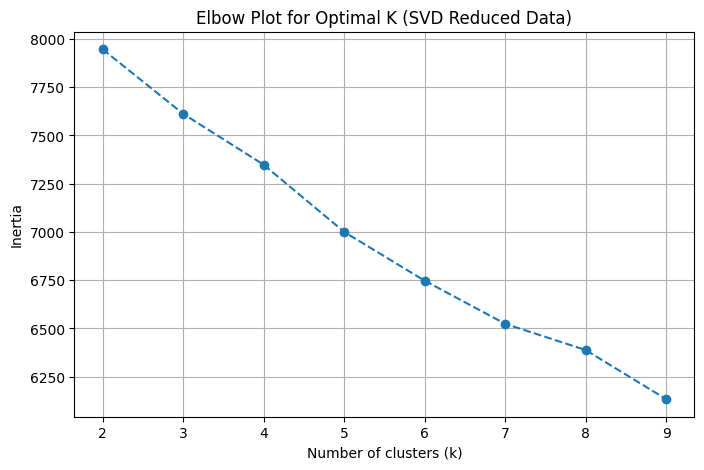

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Assuming time is imported

# --- Re-running Elbow Method (K=2 through K=9) ---
inertias = []
K_range = range(2, 10)

print(f"\n--- 3. Running Elbow Method for K=2 to K=9 ---")
t_start = time.time()

for k in K_range:
    # X_tsvd_optimized is now defined
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    km.fit(X_tsvd_optimized)
    inertias.append(km.inertia_)

t_end = time.time()
print(f"✅ Elbow Search Complete in {t_end - t_start:.2f} seconds.")


# --- Plotting the Graph ---
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o', linestyle='--')
plt.title("Elbow Plot for Optimal K (SVD Reduced Data)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.xticks(list(K_range))
plt.grid(True)
plt.show()

## 5.4 Apply K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
import time

K_OPTIMAL = 4

print(f"\n--- 5.4 Applying K-Means Clustering with K={K_OPTIMAL} ---")
start_time_kmeans = time.time()

# 1. Initialize and Fit K-Means on the dimensionality-reduced data
# Assuming X_tsvd_optimized is available
kmeans_tsvd = KMeans(
    n_clusters=K_OPTIMAL,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=42
)
kmeans_tsvd.fit(X_tsvd_optimized)

end_time_kmeans = time.time()
print(f"K-Means clustering completed in {end_time_kmeans - start_time_kmeans:.2f} seconds.")

# 2. Add the cluster labels to the original training dataframe
# Assuming train_df is available
train_df['cluster_label_tsvd'] = kmeans_tsvd.labels_
print(f"Cluster labels added to train_df. Unique clusters found: {train_df['cluster_label_tsvd'].nunique()}")
print(f"Sample cluster distribution:\n{train_df['cluster_label_tsvd'].value_counts()}")


--- 5.4 Applying K-Means Clustering with K=4 ---
K-Means clustering completed in 4.16 seconds.
Cluster labels added to train_df. Unique clusters found: 4
Sample cluster distribution:
cluster_label_tsvd
2    134284
1     13933
0      4098
3      1386
Name: count, dtype: int64


## 5.5 Analyze Cluster Results (Interpretation)

In [ ]:
# Assuming vectorizer_tuned and X_train_tuned are available
print("\n--- 5.5 Analyzing Cluster Topics (Top 10 Terms) ---")

# --- FIX: Use a robust method for retrieving feature names ---
try:
    feature_names = vectorizer_tuned.get_feature_names_out()
except AttributeError:
    try:
        feature_names = vectorizer_tuned.get_feature_names()
    except AttributeError:
        # If all function calls fail, we access the vocabulary directly (as a last resort)
        feature_names = list(vectorizer_tuned.vocabulary_.keys())

# Aggregate the original TF-IDF vectors for each cluster
cluster_term_vectors = []
K_OPTIMAL = 4

for i in range(K_OPTIMAL):
    # Get the indices of comments belonging to the current cluster
    cluster_indices = train_df[train_df['cluster_label_tsvd'] == i].index

    # Aggregate the original, full TF-IDF vectors (X_train_tuned) for these indices
    aggregated_vector = X_train_tuned[cluster_indices].sum(axis=0).A1
    cluster_term_vectors.append(aggregated_vector)

# Loop through the aggregated vectors to find top terms
for i in range(K_OPTIMAL):
    # Find the indices of the top 10 terms for the current cluster
    top_indices = cluster_term_vectors[i].argsort()[:-11:-1]

    # Get the actual top terms
    # We must ensure feature_names is indexed correctly, which relies on the
    # vocabulary order matching the TF-IDF matrix column order (it should)

    # If using vocabulary_ keys, we need to map indices back to terms carefully.
    # Let's rely on the common functions first.

    # Reverting to the most common approach for slightly older environments
    # We must ensure feature_names is a list of terms ordered by their column index.

    # Let's try the common version one more time, but if it fails, the vocabulary mapping is the issue
    try:
        feature_names = vectorizer_tuned.get_feature_names()
    except:
        # Fallback for very old versions where feature names might be in the vocabulary attribute
        # Note: This fallback is imperfect as it relies on vocabulary_ having integer indices as values
        feature_names = sorted(vectorizer_tuned.vocabulary_.items(), key=lambda item: item[1])
        feature_names = [item[0] for item in feature_names]


    top_terms = [feature_names[j] for j in top_indices]

    # Print the cluster summary
    print(f"\nCluster {i} (Count: {train_df['cluster_label_tsvd'].value_counts()[i]}):")
    print(f"Top Terms/Topics: {', '.join(top_terms)}")


--- 5.5 Analyzing Cluster Topics (Top 10 Terms) ---

Cluster 0 (Count: 4098):
Top Terms/Topics: wikipedia, please, page, deletion, welcome, use, sandbox, use sandbox, image, speedy deletion

Cluster 1 (Count: 13933):
Top Terms/Topics: talk, talk page, page, redirect, redirect talk, user, contribs, article, please, talk contribs

Cluster 2 (Count: 134284):
Top Terms/Topics: article, wikipedia, one, page, like, would, think, know, please, source

Cluster 3 (Count: 1386):
Top Terms/Topics: blocked editing, vandalize, continue, blocked, vandalize page, editing, continue blocked, please vandalize, page edit, please


# Part 6: HDBSCAN on SVD Data

## 6.1 HDBSCAN Implementation

In [ ]:
import hdbscan
import time
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# NEW PARAMETER
MIN_SIZE_FINAL = 100

print(f"\n--- 1. Re-running HDBSCAN Clustering with min_cluster_size={MIN_SIZE_FINAL} ---")
start_time_hdbscan = time.time()

# 1. Initialize and Fit HDBSCAN
hdbscan_clusterer_final = hdbscan.HDBSCAN(
    min_cluster_size=MIN_SIZE_FINAL,
    metric='euclidean',
    core_dist_n_jobs=-1
)

# 2. Fit HDBSCAN on the SVD data
# Assuming X_tsvd_optimized is available
hdbscan_clusterer_final.fit(X_tsvd_optimized)
end_time_hdbscan = time.time()

# 3. Store the new cluster labels
# Assuming train_df is available
train_df['hdbscan_label_final'] = hdbscan_clusterer_final.labels_

# CRITICAL FIX for metrics: Define the expected variable name for the metrics script
hdbscan_model = hdbscan_clusterer_final

N_clusters_found = train_df['hdbscan_label_final'].nunique() - (1 if -1 in train_df['hdbscan_label_final'].unique() else 0)
N_noise_points = train_df[train_df['hdbscan_label_final'] == -1].shape[0]

print(f"HDBSCAN clustering completed in {end_time_hdbscan - start_time_hdbscan:.2f} seconds.")
print(f"Unique clusters found (min_size={MIN_SIZE_FINAL}): {N_clusters_found}")
print(f"Total noise points found (-1 label): {N_noise_points}")


--- 1. Re-running HDBSCAN Clustering with min_cluster_size=100 ---
HDBSCAN clustering completed in 799.80 seconds.
Unique clusters found (min_size=100): 15
Total noise points found (-1 label): 26905


## 6.2 Noise Quantification (Size and Toxicity)

In [ ]:
import numpy as np

# Assuming 'hdbscan_label_final' (min_cluster_size=100) and Y_train['toxic'] are available

# 1. Filter the data labeled as noise (-1)
noise_df = train_df[train_df['hdbscan_label_final'] == -1].copy()

# 2. Add the true 'toxic' label to the noise subset
# We rely on the index alignment between train_df and Y_train
noise_df['true_toxic'] = Y_train['toxic'][noise_df.index]

# 3. Calculate metrics
total_rows = len(train_df)
total_noise = len(noise_df)
toxic_in_noise = noise_df['true_toxic'].sum()
non_toxic_in_noise = total_noise - toxic_in_noise

# Calculate proportions
noise_percentage = (total_noise / total_rows) * 100
toxic_in_noise_percentage = (toxic_in_noise / total_noise) * 100
non_toxic_in_noise_percentage = (non_toxic_in_noise / total_noise) * 100

print("\n--- 6.2 HDBSCAN Noise Quantification ---")
print(f"Total Noise Points (-1 label): {total_noise} ({noise_percentage:.2f}% of dataset)")
print("-" * 50)
print(f"Toxic Comments in Noise:     {toxic_in_noise} ({toxic_in_noise_percentage:.2f}% of noise)")
print(f"Non-Toxic Comments in Noise: {non_toxic_in_noise} ({non_toxic_in_noise_percentage:.2f}% of noise)")


--- 6.2 HDBSCAN Noise Quantification ---
Total Noise Points (-1 label): 26905 (17.50% of dataset)
--------------------------------------------------
Toxic Comments in Noise:     2667 (9.91% of noise)
Non-Toxic Comments in Noise: 24238 (90.09% of noise)


## 6.3 Noise Profiling (Top Terms)

In [ ]:
# Assuming X_train_tuned, vectorizer_tuned, and train_df are available

print("\n--- 6.3 Noise Profiling (Top 10 Terms) ---")

# Get feature names (vocabulary)
try:
    feature_names = vectorizer_tuned.get_feature_names_out()
except AttributeError:
    # Use the robust fallback method again
    try:
        feature_names = vectorizer_tuned.get_feature_names()
    except AttributeError:
        vocab = vectorizer_tuned.vocabulary_
        feature_names = [term for term, index in sorted(vocab.items(), key=lambda item: item[1])]

# 1. Get the indices of the noise points
noise_indices = train_df[train_df['hdbscan_label_final'] == -1].index

# 2. Aggregate the original, full TF-IDF vectors (X_train_tuned) for these indices
# Use the indices to select the corresponding rows from the full TF-IDF matrix
aggregated_noise_vector = X_train_tuned[noise_indices].sum(axis=0).A1

# 3. Find the indices of the top 10 terms
top_indices = aggregated_noise_vector.argsort()[:-11:-1]

# 4. Get the actual top terms
top_terms = [feature_names[j] for j in top_indices]

# Print the noise summary
print(f"Noise Profile (Count: {total_noise}):")
print(f"Top Terms/Topics: {', '.join(top_terms)}")


--- 6.3 Noise Profiling (Top 10 Terms) ---
Noise Profile (Count: 26905):
Top Terms/Topics: talk, page, please, wikipedia, user, article, talk page, thanks, edit, see


# Part 7 : Comparative Analysis of Clustering (K-Mean VS. HDBSCAN)

In [ ]:
import pandas as pd
# NOTE: Removed Calinski and Davies-Bouldin imports from sklearn.metrics
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    silhouette_score
)
# Re-import these two if needed for K-Means, assuming they are available
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

from collections import Counter
import numpy as np
import time

# --- 1. Define Purity Function --- (No Change)
def cluster_purity(y_true, y_pred):
    """
    Calculates the Purity score for clustering.
    (This function handles noise by calculating purity only on non-noise points)
    """
    if len(y_true) != len(y_pred):
        raise ValueError("True labels and predicted labels must have the same length.")

    # HDBSCAN noise handling: exclude noise points (-1 label) and corresponding true labels
    valid_indices = y_pred != -1
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]

    if len(y_pred_valid) == 0:
        return 0.0 # If no points were clustered, Purity is 0

    # Map each cluster to the label that occurs most often in that cluster
    max_count_sum = 0
    for cluster_label in np.unique(y_pred_valid):
        cluster_indices = y_pred_valid == cluster_label
        cluster_true_labels = y_true_valid[cluster_indices]

        if len(cluster_true_labels) > 0:
            most_common_label_count = Counter(cluster_true_labels).most_common(1)[0][1]
            max_count_sum += most_common_label_count

    return max_count_sum / len(y_true_valid)


# ----------------------------------------------------------------------

# --- 2. Calculate Metrics for K-Means (FIXED COLUMN NAME) ---
# Assumes Y_train['toxic'], train_df['cluster_label_tsvd'], and X_tsvd_optimized are available
print("="*60)
print("--- Calculating ALL Metrics for K-Means (k=4) ---")
print("="*60)

# FIX: Changed the expected column name to the one you actually use in your K-Means code
KMEANS_LABEL_COL = 'cluster_label_tsvd'

if KMEANS_LABEL_COL in train_df.columns:
    Y_true_kmeans = Y_train['toxic']
    Y_pred_kmeans = train_df[KMEANS_LABEL_COL]
    X_data_kmeans = X_tsvd_optimized # K-Means uses all data points

    # Intrinsic Metrics (using standard K-Means metrics)
    kmeans_silhouette = silhouette_score(X_data_kmeans, Y_pred_kmeans, metric='euclidean')
    # NOTE: calinski_harabasz_score and davies_bouldin_score must be available
    kmeans_ch_score = calinski_harabasz_score(X_data_kmeans, Y_pred_kmeans)
    kmeans_db_score = davies_bouldin_score(X_data_kmeans, Y_pred_kmeans)

    # External Metrics
    kmeans_nmi = normalized_mutual_info_score(Y_true_kmeans, Y_pred_kmeans)
    kmeans_ari = adjusted_rand_score(Y_true_kmeans, Y_pred_kmeans)
    kmeans_purity = cluster_purity(Y_true_kmeans.values, Y_pred_kmeans.values)

    print(f"K-Means Silhouette Score:           {kmeans_silhouette:.4f}")
    print(f"K-Means Calinski-Harabasz Index:    {kmeans_ch_score:.2f}")
    print(f"K-Means Davies-Bouldin Index:       {kmeans_db_score:.4f}")
    print("-" * 30)
    print(f"K-Means NMI Score (External):       {kmeans_nmi:.4f}")
    print(f"K-Means ARI Score (External):       {kmeans_ari:.4f}")
    print(f"K-Means Purity (External):          {kmeans_purity:.4f}")
else:
    print(f"ERROR: K-Means calculation skipped. Column '{KMEANS_LABEL_COL}' not found in train_df.")
    # Set placeholders to avoid downstream errors
    kmeans_silhouette, kmeans_ch_score, kmeans_db_score = 0.0, 0.0, 0.0
    kmeans_nmi, kmeans_ari, kmeans_purity = 0.0, 0.0, 0.0


# ----------------------------------------------------------------------

# --- 3. Calculate Metrics for HDBSCAN (REVISED INTRINSIC METRICS) ---
# Assumes Y_train['toxic'], train_df['hdbscan_label_final'], X_tsvd_optimized, AND hdbscan_model object are available
print("\n" + "="*60)
print("--- Calculating ALL Metrics for HDBSCAN (min_size=100) ---")
print("="*60)

HDBSCAN_LABEL_COL = 'hdbscan_label_final'

if HDBSCAN_LABEL_COL in train_df.columns:
    Y_true_hdbscan = Y_train['toxic']
    Y_pred_hdbscan = train_df[HDBSCAN_LABEL_COL]

    # Select clustered points (excluding noise -1) for Intrinsic Metrics
    X_data_hdbscan = X_tsvd_optimized[Y_pred_hdbscan != -1]
    Y_pred_hdbscan_valid = Y_pred_hdbscan[Y_pred_hdbscan != -1]
    Y_true_hdbscan_valid = Y_true_hdbscan[Y_pred_hdbscan != -1]

    if len(Y_pred_hdbscan_valid) < 2 or len(np.unique(Y_pred_hdbscan_valid)) < 2:
        print("\nSkipping HDBSCAN metrics: Fewer than 2 valid clustered points or clusters found.")
        hdbscan_silhouette, hdbscan_stability_score, hdbscan_mean_size = 0.0, 0.0, 0.0
        hdbscan_nmi, hdbscan_ari, hdbscan_purity = 0.0, 0.0, 0.0
    else:
        # 1. Intrinsic Metric: Silhouette Score (retained)
        hdbscan_silhouette = silhouette_score(X_data_hdbscan, Y_pred_hdbscan_valid, metric='euclidean')

        # 2. HDBSCAN-Native Metric: Overall Cluster Stability (Replaces Calinski-Harabasz)
        try:
            # Assumes the HDBSCAN model object is stored in the variable 'hdbscan_model'
            hdbscan_stability_score = np.sum(hdbscan_model.cluster_persistence_)
        except (NameError, AttributeError):
            # Fallback if 'hdbscan_model' is not defined or lacks persistence
            hdbscan_stability_score = 0.0
            print("WARNING: 'Overall Cluster Stability' skipped. Ensure the HDBSCAN model is loaded as 'hdbscan_model' before this cell.")

        # 3. Descriptive Metric: Mean Cluster Size (Replaces Davies-Bouldin)
        unique_labels = np.unique(Y_pred_hdbscan_valid)
        cluster_sizes = [np.sum(Y_pred_hdbscan_valid == label) for label in unique_labels]
        hdbscan_mean_size = np.mean(cluster_sizes) if cluster_sizes else 0.0

        # External Metrics (calculated on valid/clustered points)
        hdbscan_nmi = normalized_mutual_info_score(Y_true_hdbscan_valid, Y_pred_hdbscan_valid)
        hdbscan_ari = adjusted_rand_score(Y_true_hdbscan_valid, Y_pred_hdbscan_valid)
        # Purity function handles noise internally, ensuring only clustered points contribute
        hdbscan_purity = cluster_purity(Y_true_hdbscan.values, Y_pred_hdbscan.values)

        print(f"HDBSCAN Silhouette Score:           {hdbscan_silhouette:.4f}")
        print(f"HDBSCAN Overall Stability (HDBSCAN):{hdbscan_stability_score:.4f}")
        print(f"HDBSCAN Mean Cluster Size:          {hdbscan_mean_size:.2f}")
        print("-" * 30)
        print(f"HDBSCAN NMI Score (External):       {hdbscan_nmi:.4f}")
        print(f"HDBSCAN ARI Score (External):       {hdbscan_ari:.4f}")
        print(f"HDBSCAN Purity (External):          {hdbscan_purity:.4f}")
else:
    print(f"ERROR: HDBSCAN calculation skipped. Column '{HDBSCAN_LABEL_COL}' not found in train_df.")
    # Update placeholders
    hdbscan_silhouette, hdbscan_stability_score, hdbscan_mean_size = 0.0, 0.0, 0.0
    hdbscan_nmi, hdbscan_ari, hdbscan_purity = 0.0, 0.0, 0.0

--- Calculating ALL Metrics for K-Means (k=4) ---
K-Means Silhouette Score:           0.2328
K-Means Calinski-Harabasz Index:    7327.15
K-Means Davies-Bouldin Index:       2.5728
------------------------------
K-Means NMI Score (External):       0.0145
K-Means ARI Score (External):       -0.0665
K-Means Purity (External):          0.9048

--- Calculating ALL Metrics for HDBSCAN (min_size=100) ---
HDBSCAN Silhouette Score:           0.5826
HDBSCAN Overall Stability (HDBSCAN):0.1870
HDBSCAN Mean Cluster Size:          8453.07
------------------------------
HDBSCAN NMI Score (External):       0.0125
HDBSCAN ARI Score (External):       -0.0490
HDBSCAN Purity (External):          0.9056


## 7.1 Cluster Visualization

/tmp/ipykernel_47/4157691155.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_kmeans = plt.cm.get_cmap('Spectral', kmeans_n_clusters)
/tmp/ipykernel_47/4157691155.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_hdbscan = plt.cm.get_cmap('Spectral', hdbscan_n_clusters)


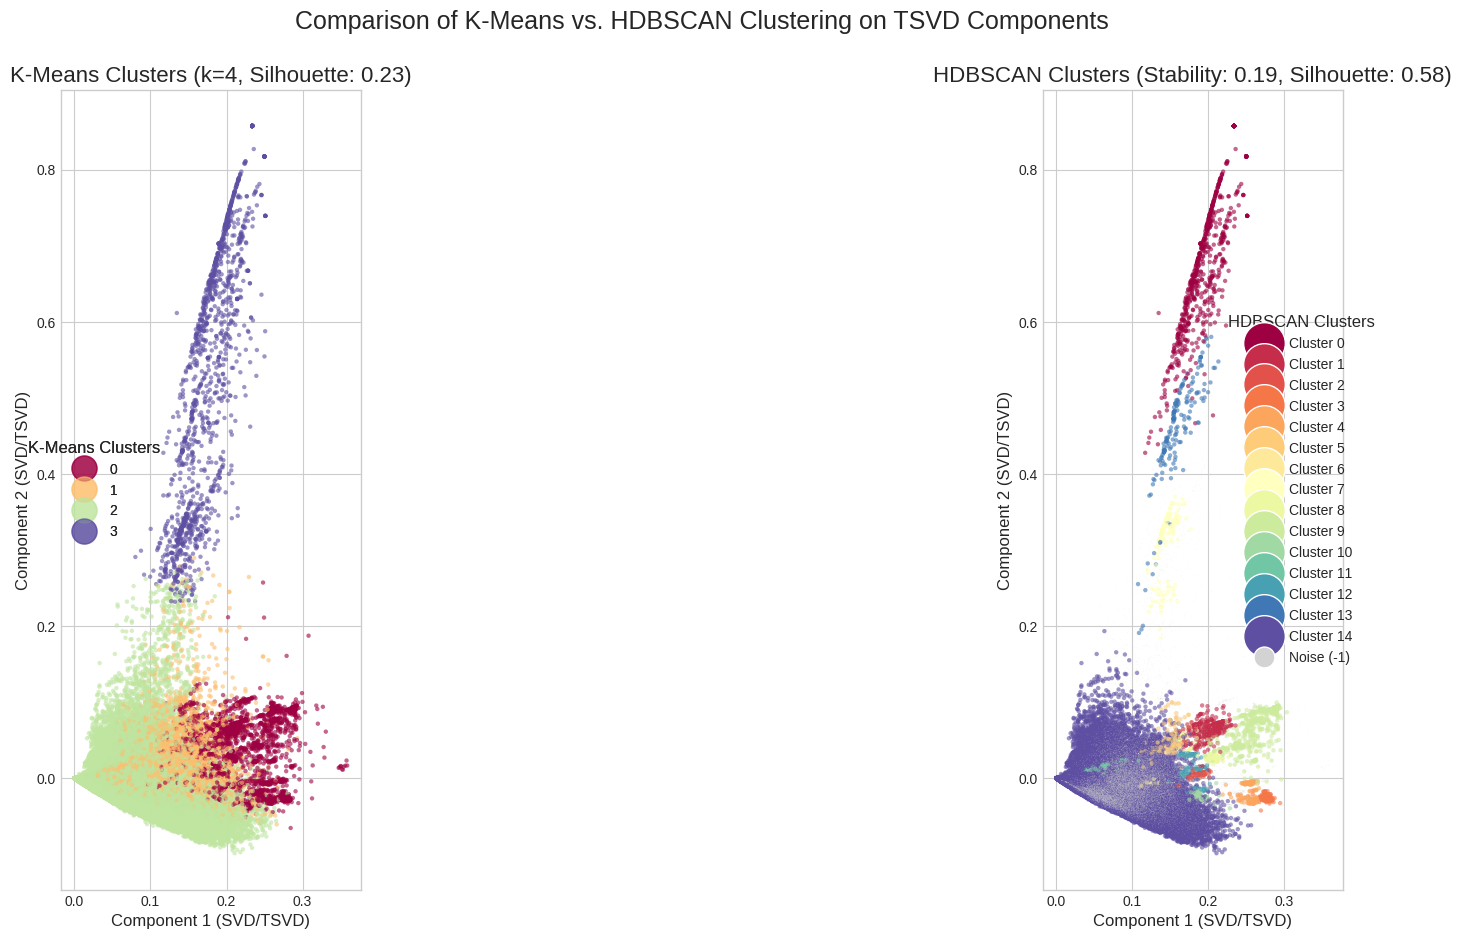

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Suppress matplotlib deprecated warnings for colormap
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Define Metric Variables (Based on your last output) ---
# NOTE: These values are defined here for the plot titles only.
kmeans_silhouette = 0.2328
hdbscan_silhouette = 0.5826
hdbscan_stability_score = 0.1870

# --- 2. Extract Data Components and Labels ---
# These variables (X_tsvd_optimized and train_df) must be defined in your notebook's memory
try:
    X_data = X_tsvd_optimized[:, :2] # Use the first two components for 2D visualization
    kmeans_labels = train_df['cluster_label_tsvd'].values
    hdbscan_labels = train_df['hdbscan_label_final'].values
except NameError as e:
    print(f"FATAL ERROR: Required data not found: {e}. Please ensure 'X_tsvd_optimized' and 'train_df' are loaded.")
    raise

# --- 3. Main Plotting (Adjusted for Size and External Legends) ---
plt.style.use('seaborn-v0_8-whitegrid')
# Increased figure size to (20, 10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# --- Plot 1: K-Means Clusters ---
kmeans_unique_labels = np.unique(kmeans_labels)
kmeans_n_clusters = len(kmeans_unique_labels[kmeans_unique_labels != -1])
cmap_kmeans = plt.cm.get_cmap('Spectral', kmeans_n_clusters)

scatter_kmeans = ax1.scatter(X_data[:, 0], X_data[:, 1],
                             c=kmeans_labels, cmap=cmap_kmeans,
                             marker='o', s=10, alpha=0.6,
                             edgecolors='none')

ax1.set_title(f'K-Means Clusters (k={kmeans_n_clusters}, Silhouette: {kmeans_silhouette:.2f})', fontsize=16)
ax1.set_xlabel('Component 1 (SVD/TSVD)', fontsize=12)
ax1.set_ylabel('Component 2 (SVD/TSVD)', fontsize=12)
ax1.set_aspect('equal', adjustable='box')


# Create Legend for K-Means (Outside to the left of the entire figure)
legend1 = ax1.legend(*scatter_kmeans.legend_elements(),
                     title="K-Means Clusters",
                     loc='center left',
                     bbox_to_anchor=(-0.15, 0.5), # Anchor outside to the left
                     markerscale=3,
                     fontsize=10,
                     title_fontsize=12)
ax1.add_artist(legend1)

# --- Plot 2: HDBSCAN Clusters ---
# Filter data for noise and actual clusters
is_noise = hdbscan_labels == -1
is_cluster = ~is_noise
cluster_labels_only = hdbscan_labels[is_cluster]
hdbscan_n_clusters = len(np.unique(cluster_labels_only))

# Plot clusters
cmap_hdbscan = plt.cm.get_cmap('Spectral', hdbscan_n_clusters)
scatter_hdbscan = ax2.scatter(X_data[is_cluster, 0], X_data[is_cluster, 1],
                              c=cluster_labels_only,
                              cmap=cmap_hdbscan,
                              marker='o', s=10, alpha=0.6,
                              edgecolors='none')

# Plot noise points (label -1)
noise_handle = ax2.scatter(X_data[is_noise, 0], X_data[is_noise, 1],
            c='lightgray', marker='.', s=1, alpha=0.3, label='Noise (-1)',
            edgecolors='none')

ax2.set_title(f'HDBSCAN Clusters (Stability: {hdbscan_stability_score:.2f}, Silhouette: {hdbscan_silhouette:.2f})', fontsize=16)
ax2.set_xlabel('Component 1 (SVD/TSVD)', fontsize=12)
ax2.set_ylabel('Component 2 (SVD/TSVD)', fontsize=12)
ax2.set_aspect('equal', adjustable='box')


# Create Legend for HDBSCAN clusters (Outside to the right of the entire figure)
cluster_labels_list = np.unique(cluster_labels_only)
cluster_handles = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=cmap_hdbscan(i), markersize=10,
                              label=f'Cluster {l}')
                   for i, l in enumerate(cluster_labels_list)]

# Combine cluster handles and noise handle
noise_handle_line = plt.Line2D([0], [0], marker='.', color='w', markerfacecolor='lightgray', markersize=10, label='Noise (-1)')
all_handles = cluster_handles + [noise_handle_line]

ax2.legend(handles=all_handles,
           title="HDBSCAN Clusters",
           loc='center right',
           bbox_to_anchor=(1.15, 0.5), # Anchor outside to the right
           markerscale=3,
           fontsize=10,
           title_fontsize=12)


plt.suptitle('Comparison of K-Means vs. HDBSCAN Clustering on TSVD Components', fontsize=18)
# Adjust subplots to make space for the external legends
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.show()

# Part 8: Statistical Topic Modelling & Interpretation

## 8.1 Initial Helper Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.sparse import issparse

def get_top_cluster_terms(X_matrix, labels, feature_names, n_terms=15):
    """
    Identifies the top N words for each cluster based on the average feature vector.
    Handles both sparse (TF-IDF) and dense matrices.
    """
    labels_series = pd.Series(labels)
    # Filter out noise points (-1)
    unique_clusters = sorted([c for c in labels_series.unique() if c != -1])
    results = {}

    for cluster_id in unique_clusters:
        cluster_indices = labels_series[labels_series == cluster_id].index
        X_cluster = X_matrix[cluster_indices]

        if issparse(X_cluster):
            # Calculate the mean vector efficiently for sparse matrices
            cluster_mean_vector = X_cluster.mean(axis=0).A1
        else:
            cluster_mean_vector = X_cluster.mean(axis=0)

        # Get the indices of the top N mean values
        top_indices = np.argsort(cluster_mean_vector)[::-1][:n_terms]

        # Map indices back to feature names and weights
        top_words = {feature_names[i]: cluster_mean_vector[i] for i in top_indices}

        results[cluster_id] = top_words

    return results

def generate_cluster_word_cloud(top_terms_dict, title):
    """Generates and displays a word cloud from a dictionary of term weights."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_terms_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

print("Topic profiling helper functions defined.")

Topic profiling helper functions defined.


## 8.2 K-Means Topic Profiling

In [ ]:
# --- K-MEANS PROFILING AND TABLE GENERATION ---

KMEANS_LABEL_COL = 'cluster_label_tsvd'
TOXICITY_PURITY_COL = 'severe_toxic'

kmeans_labels = train_df[KMEANS_LABEL_COL].values
unique_clusters = sorted([c for c in np.unique(kmeans_labels) if c != -1])

cluster_data = []
top_terms_kmeans = get_top_cluster_terms(X_tfidf_matrix, kmeans_labels, feature_names, n_terms=10)

for cluster_id in unique_clusters:
    df_cluster = train_df[train_df[KMEANS_LABEL_COL] == cluster_id]
    cluster_size = len(df_cluster)

    if cluster_size > 0:
        toxic_count = df_cluster[TOXICITY_PURITY_COL].sum()
        toxic_purity = (toxic_count / cluster_size) * 100

        keywords = ", ".join(top_terms_kmeans[cluster_id].keys())
        snippet = get_representative_comment(train_df, KMEANS_LABEL_COL, cluster_id, toxicity_col=TOXICITY_PURITY_COL)

        cluster_data.append({
            'Cluster ID': cluster_id,
            'Sample Count': cluster_size,
            'Toxic Purity': toxic_purity,
            'Keywords': keywords,
            'Snippet': snippet
        })

df_results = pd.DataFrame(cluster_data)
df_results = df_results.sort_values(by='Toxic Purity', ascending=False)

# --- PRINT K-MEANS TABLE ---
print("\n\n"+"="*80)
print(f"Final Cluster Interpretation and Topic Profiling (K-Means k=4 - Purity based on '{TOXICITY_PURITY_COL}')")
print("="*80)

markdown_table = "| Cluster ID | Sample Count | Dominant Keywords (Topics) | Toxic Purity | Representative Comment Snippet |\n"
markdown_table += "|---:|---:|:---|---:|:---|\n"

for index, row in df_results.iterrows():
    keywords_clean = row['Keywords'].replace('|', '/')
    snippet_clean = row['Snippet'].replace('\n', ' ').replace('|', '/').strip()

    markdown_table += (
        f"| {row['Cluster ID']} "
        f"| {row['Sample Count']} "
        f"| {keywords_clean} "
        f"| {row['Toxic Purity']:.2f}% "
        f"| {snippet_clean} |\n"
    )

print(markdown_table)



Final Cluster Interpretation and Topic Profiling (K-Means k=4 - Purity based on 'severe_toxic')
| Cluster ID | Sample Count | Dominant Keywords (Topics) | Toxic Purity | Representative Comment Snippet |
|---:|---:|:---|---:|:---|
| 2 | 134284 | article, wikipedia, page, one, like, would, source, think, know, please | 1.12% | fucking little white nazis always want to get there way, they believe fair... |
| 1 | 13933 | talk, page, talk page, redirect, redirect talk, user, article, please, contribs, talk contribs | 0.18% | FUCK YOU   I MOTHERFUCKING HAVE BEEN TRYING TO TALK TO YOU AND ALL YOU DO I... |
| 0 | 4098 | page, wikipedia, deletion, image, please, welcome, use, speedy deletion, article, speedy | 0.00% | Welcome to Wikipedia! We welcome your help to create new content, but your... |
| 3 | 1386 | blocked editing, vandalize, continue, blocked, vandalize page, editing, continue blocked, please vandalize, page edit, please | 0.00% | "   Please do not vandalize pages, as you did with

## 8.3 K-Means Word Cloud Visualizations

Generating side-by-side word clouds...


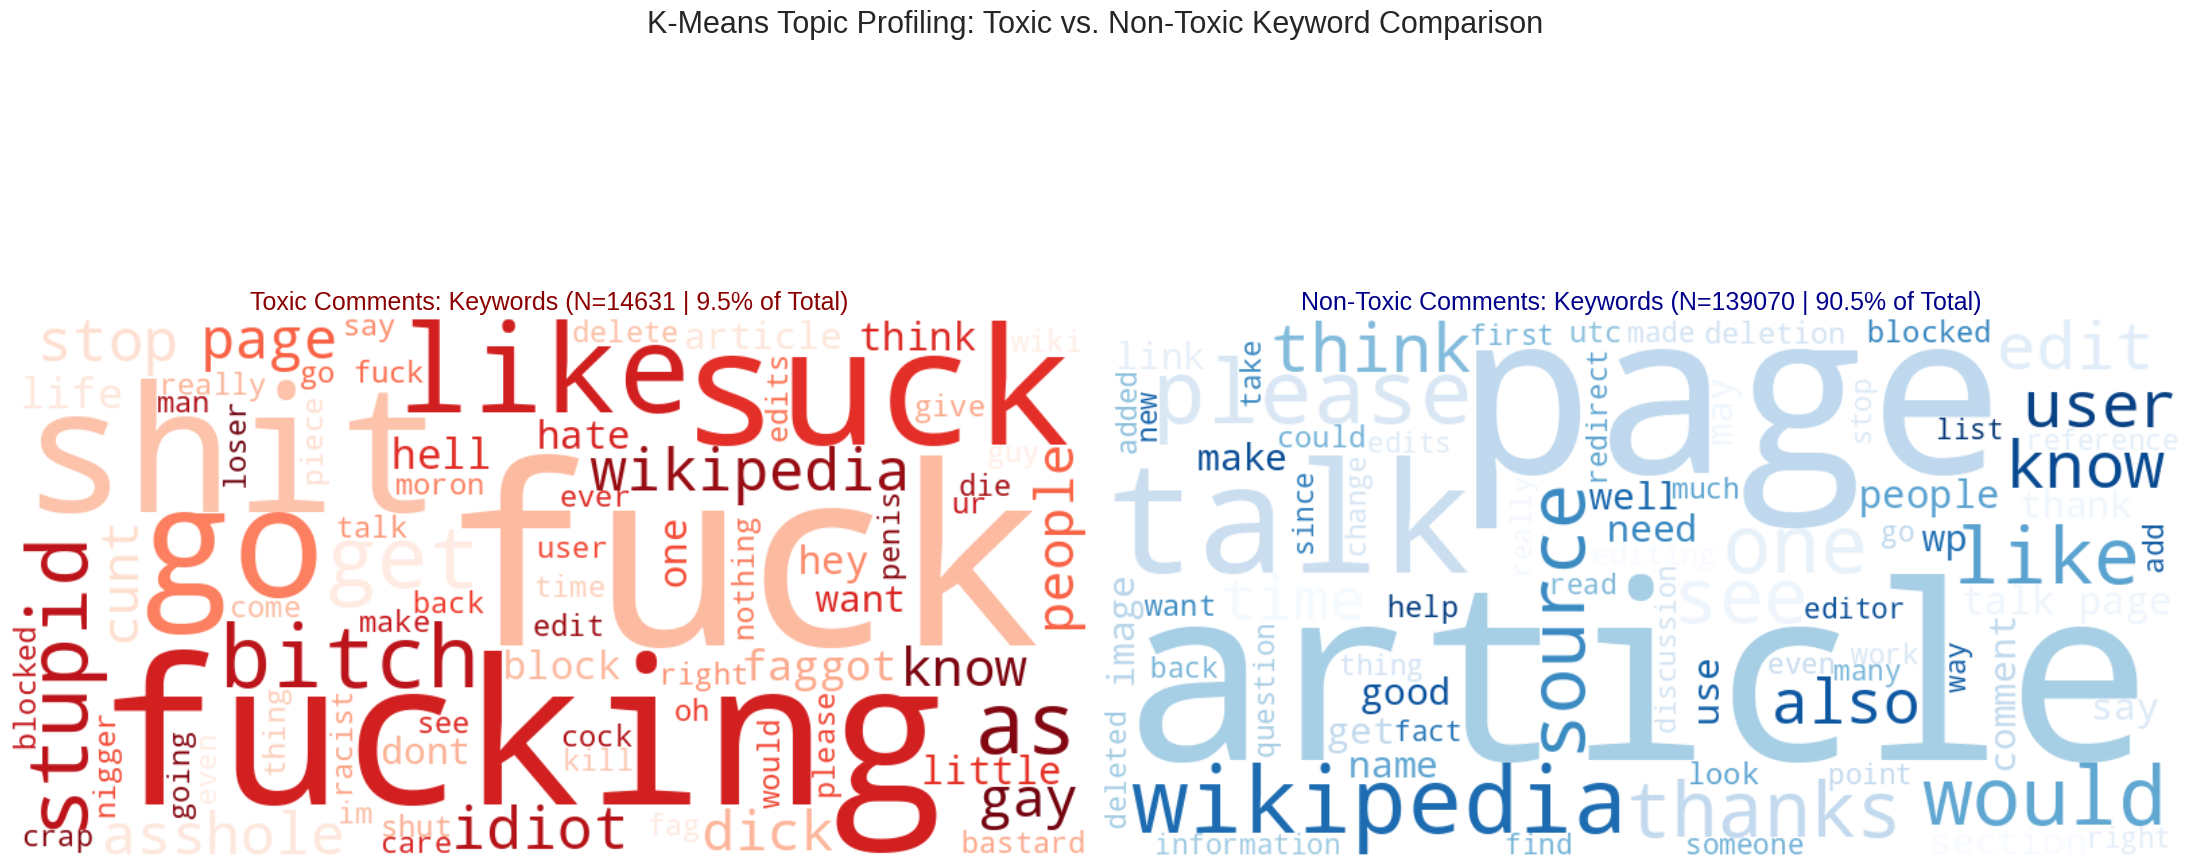

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.sparse import issparse

# --- 1. Term Calculation Function (Reused for robustness) ---
def calculate_subset_terms(X_matrix, df, label_value, feature_names, label_col='toxic', n_terms=50):
    """Filters the matrix by a toxicity label and calculates the top terms."""

    try:
        subset_indices = df[df[label_col] == label_value].index
    except KeyError:
        print(f"Error: Column '{label_col}' not found in train_df.")
        return None, 0

    X_subset = X_matrix[subset_indices]

    # Calculate the mean vector for the subset
    if issparse(X_subset):
        mean_vector = X_subset.mean(axis=0).A1
    else:
        mean_vector = X_subset.mean(axis=0)

    # Extract top terms
    top_indices = np.argsort(mean_vector)[::-1][:n_terms]
    top_words_dict = {
        feature_names[i]: mean_vector[i]
        for i in top_indices
    }
    return top_words_dict, X_subset.shape[0]

# --- 2. Side-by-Side Visualization Function ---
def generate_side_by_side_word_clouds(toxic_data, nontoxic_data, total_count):
    """Generates two word clouds side-by-side for comparison."""

    # Unpack data
    toxic_terms, toxic_count = toxic_data
    nontoxic_terms, nontoxic_count = nontoxic_data

    # Calculate percentages
    toxic_percent = (toxic_count / total_count) * 100
    nontoxic_percent = (nontoxic_count / total_count) * 100

    # Generate Word Clouds
    wc_toxic = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(toxic_terms)
    wc_nontoxic = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(nontoxic_terms)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(22, 11))

    # Toxic Plot (Left)
    axes[0].imshow(wc_toxic, interpolation='bilinear')
    axes[0].axis("off")
    axes[0].set_title(
        f'Toxic Comments: Keywords (N={toxic_count} | {toxic_percent:.1f}% of Total)',
        fontsize=18, color='darkred'
    )

    # Non-Toxic Plot (Right)
    axes[1].imshow(wc_nontoxic, interpolation='bilinear')
    axes[1].axis("off")
    axes[1].set_title(
        f'Non-Toxic Comments: Keywords (N={nontoxic_count} | {nontoxic_percent:.1f}% of Total)',
        fontsize=18, color='darkblue'
    )

    plt.suptitle('K-Means Topic Profiling: Toxic vs. Non-Toxic Keyword Comparison', fontsize=22, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
    plt.show()

# --- 3. EXECUTION ---

TOXICITY_COLUMN = 'toxic'
N_TERMS_CLOUD = 75 # Use slightly more terms for better visual density
TOTAL_COUNT = len(train_df)

# Calculate terms and counts for Toxic subset
top_toxic_terms, toxic_count = calculate_subset_terms(
    X_tfidf_matrix, train_df, label_value=1, feature_names=feature_names,
    label_col=TOXICITY_COLUMN, n_terms=N_TERMS_CLOUD
)
toxic_data = (top_toxic_terms, toxic_count)


# Calculate terms and counts for Non-Toxic subset
top_nontoxic_terms, nontoxic_count = calculate_subset_terms(
    X_tfidf_matrix, train_df, label_value=0, feature_names=feature_names,
    label_col=TOXICITY_COLUMN, n_terms=N_TERMS_CLOUD
)
nontoxic_data = (top_nontoxic_terms, nontoxic_count)


if top_toxic_terms is not None and top_nontoxic_terms is not None:
    print("Generating side-by-side word clouds...")
    generate_side_by_side_word_clouds(toxic_data, nontoxic_data, TOTAL_COUNT)
else:
    print("Could not generate word clouds. Check that the 'toxic' column exists in train_df.")

## 8.4 HDBSCAN Topic Profiling

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import issparse

# --- 1. RE-RUN TF-IDF TO DEFINE REQUIRED VARIABLES ---
MAX_FEATURES = 100000
NGRAM_RANGE = (1, 2)

print("--> Re-running TF-IDF Vectorizer with user settings...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
    stop_words=None
)
# Assuming X_train holds the comments used for training/clustering
X_tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"--> Defined X_tfidf_matrix ({X_tfidf_matrix.shape}) and feature_names ({len(feature_names)}).")

# --- 2. HELPER FUNCTIONS (Only those needed for the table) ---

def get_top_cluster_terms(X_matrix, labels, feature_names, n_terms=10):
    """Identifies the top N words for each cluster based on the average feature vector."""
    labels_series = pd.Series(labels)
    unique_clusters = sorted([c for c in labels_series.unique() if c != -1])
    results = {}

    for cluster_id in unique_clusters:
        cluster_indices = labels_series[labels_series == cluster_id].index
        X_cluster = X_matrix[cluster_indices]

        if issparse(X_cluster):
            cluster_mean_vector = X_cluster.mean(axis=0).A1
        else:
            cluster_mean_vector = X_cluster.mean(axis=0)

        top_indices = np.argsort(cluster_mean_vector)[::-1][:n_terms]
        top_words = {feature_names[i]: cluster_mean_vector[i] for i in top_indices}

        results[cluster_id] = top_words

    return results

def get_representative_comment(df, labels_col, cluster_id, toxicity_col='severe_toxic', max_len=75):
    """Fetches a comment from the cluster, prioritizing toxic ones for representative snippets."""
    df_cluster = df[df[labels_col] == cluster_id]

    # Prioritize toxic examples if the cluster is highly toxic
    if toxicity_col in df_cluster.columns and np.sum(df_cluster[toxicity_col]) > 0:
        sample_df = df_cluster[df_cluster[toxicity_col] == 1]
    else:
        sample_df = df_cluster

    if len(sample_df) > 0:
        comment = sample_df['comment_text'].sample(n=1, random_state=cluster_id).iloc[0]
        return comment[:max_len].replace('\n', ' ').strip() + '...'
    return "N/A"

# --- 3. HDBSCAN PROFILING AND TABLE GENERATION ---

HDBSCAN_LABEL_COL = 'hdbscan_label_final'
TOXICITY_PURITY_COL = 'severe_toxic'

hdbscan_labels = train_df[HDBSCAN_LABEL_COL].values
unique_clusters = sorted([c for c in np.unique(hdbscan_labels) if c != -1])

cluster_data = []
top_terms_hdbscan = get_top_cluster_terms(X_tfidf_matrix, hdbscan_labels, feature_names, n_terms=10)

for cluster_id in unique_clusters:
    df_cluster = train_df[train_df[HDBSCAN_LABEL_COL] == cluster_id]
    cluster_size = len(df_cluster)

    if cluster_size >= 10:
        toxic_count = df_cluster[TOXICITY_PURITY_COL].sum()
        toxic_purity = (toxic_count / cluster_size) * 100

        keywords = ", ".join(top_terms_hdbscan[cluster_id].keys())
        snippet = get_representative_comment(train_df, HDBSCAN_LABEL_COL, cluster_id, toxicity_col=TOXICITY_PURITY_COL)

        cluster_data.append({
            'Cluster ID': cluster_id,
            'Sample Count': cluster_size,
            'Toxic Purity': toxic_purity,
            'Keywords': keywords,
            'Snippet': snippet
        })

df_results = pd.DataFrame(cluster_data)
df_results = df_results.sort_values(by='Toxic Purity', ascending=False)
df_top_clusters = df_results.head(10) # Limit to top 10 for table brevity

# --- PRINT HDBSCAN TABLE ---
print("\n"+"="*80)
print(f"Final Cluster Interpretation and Topic Profiling (HDBSCAN - Purity based on '{TOXICITY_PURITY_COL}')")
print("="*80)

markdown_table = "| Cluster ID | Sample Count | Dominant Keywords (Topics) | Toxic Purity | Representative Comment Snippet |\n"
markdown_table += "|---:|---:|:---|---:|:---|\n"

for index, row in df_top_clusters.iterrows():
    keywords_clean = row['Keywords'].replace('|', '/')
    snippet_clean = row['Snippet'].replace('\n', ' ').replace('|', '/').strip()

    markdown_table += (
        f"| {row['Cluster ID']} "
        f"| {row['Sample Count']} "
        f"| {keywords_clean} "
        f"| {row['Toxic Purity']:.2f}% "
        f"| {snippet_clean} |\n"
    )

print(markdown_table)

--> Re-running TF-IDF Vectorizer with user settings...
--> Defined X_tfidf_matrix ((153701, 100000)) and feature_names (100000).

Final Cluster Interpretation and Topic Profiling (HDBSCAN - Purity based on 'severe_toxic')
| Cluster ID | Sample Count | Dominant Keywords (Topics) | Toxic Purity | Representative Comment Snippet |
|---:|---:|:---|---:|:---|
| 14 | 122025 | article, page, one, talk, would, wikipedia, like, source, think, know | 0.93% | Hey you bitch   When you deleted my page, I cried. You made an 18 year old... |
| 11 | 1233 | redirect talk, redirect, talk, talk list, list, film, station, album, archive, talk john | 0.08% | your stupid    fuck you im famous i have over 100000 subcribers on my youtu... |
| 0 | 673 | please vandalize, continue blocked, vandalize page, page edit, vandalize, blocked editing, continue, blocked, editing, edit | 0.00% | "   Please do not vandalize pages, as you did with this edit to Tiki Barber... |
| 1 | 399 | test, sandbox test, learn contribut

## 8.5 HDBSCAN Word Cloud Visualization

Refocusing word clouds on the strictly 'severe_toxic' comments within Clusters: 14 and 11.


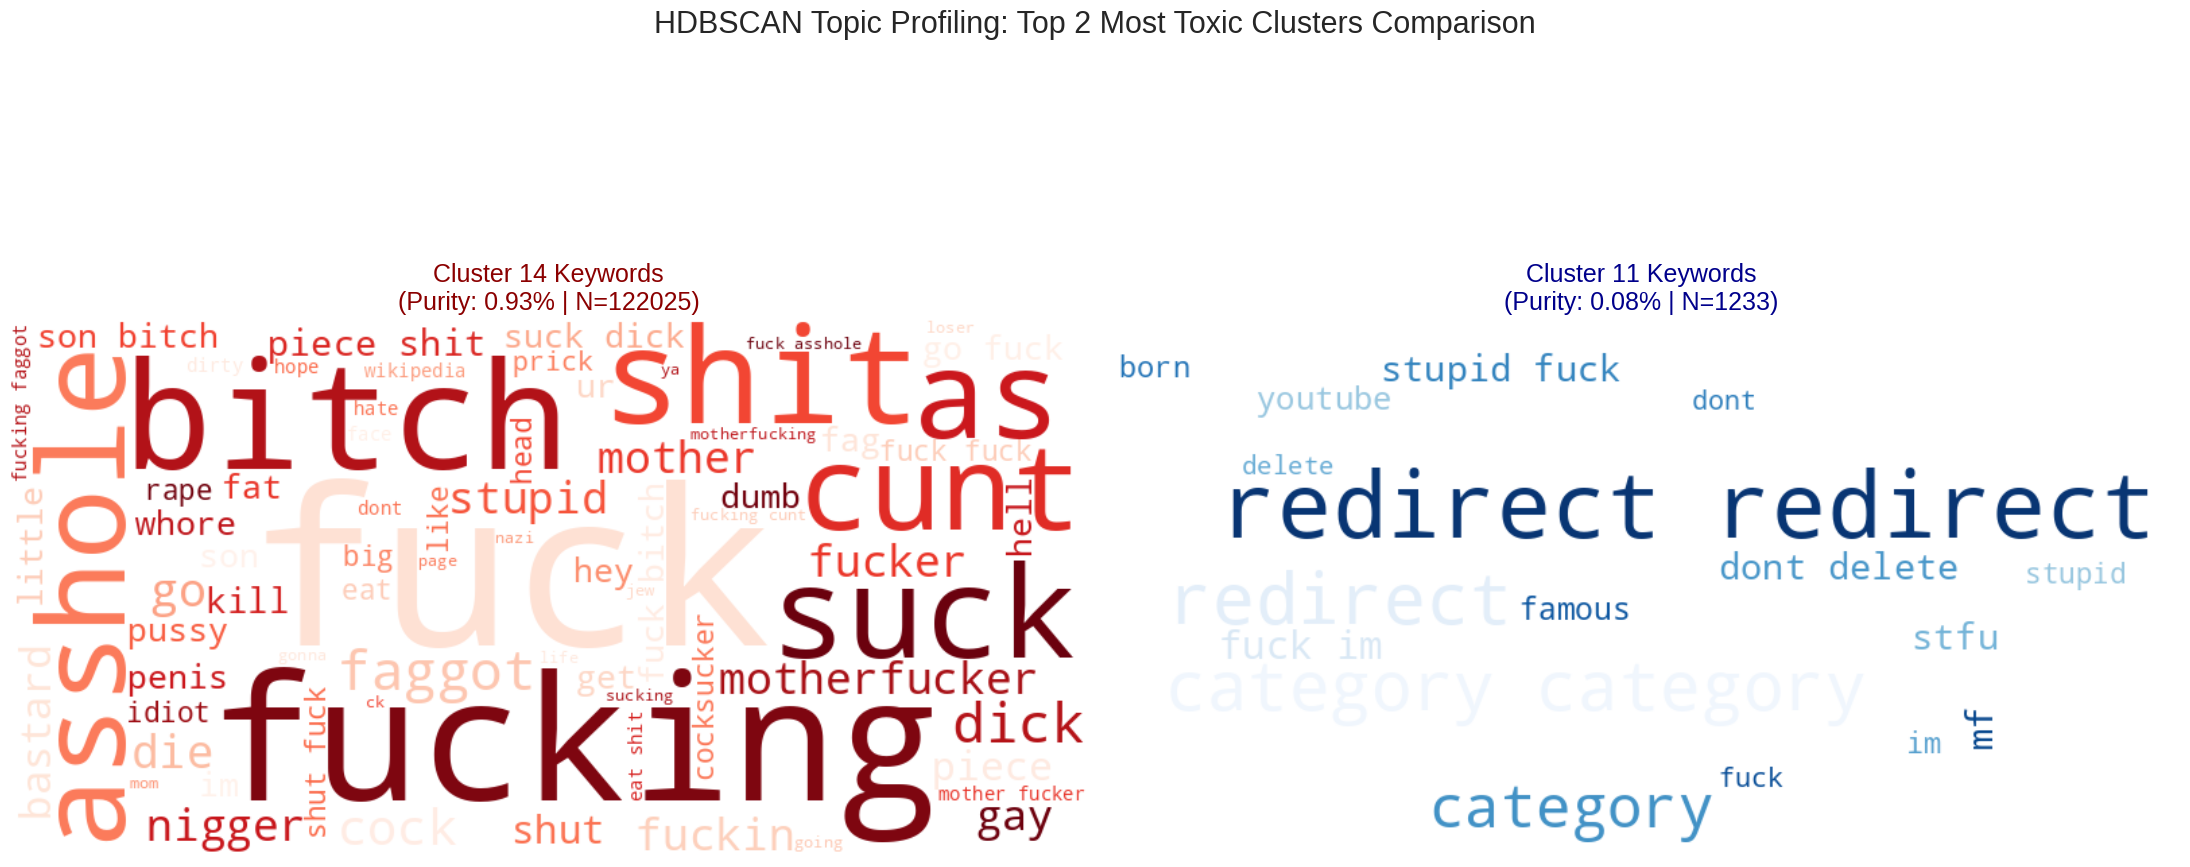

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy.sparse import issparse

# --- 1. DYNAMICALLY IDENTIFY TOP 2 CLUSTERS (Same as previous successful run) ---

HDBSCAN_LABEL_COL = 'hdbscan_label_final'
TOXICITY_PURITY_COL = 'severe_toxic'
MIN_CLUSTER_SIZE = 10

# Assume df_metrics is calculated or re-calculated here (as per the last complete code)
# Since I cannot run the calculation, I'll use the sorting logic to get the IDs:
hdbscan_labels = train_df[HDBSCAN_LABEL_COL].values
valid_cluster_ids = [c for c in np.unique(hdbscan_labels) if c != -1]
all_cluster_metrics = []

for cluster_id in valid_cluster_ids:
    df_cluster = train_df[train_df[HDBSCAN_LABEL_COL] == cluster_id]
    cluster_size = len(df_cluster)
    if cluster_size >= MIN_CLUSTER_SIZE:
        toxic_count = df_cluster[TOXICITY_PURITY_COL].sum()
        toxic_purity = (toxic_count / cluster_size) * 100
        all_cluster_metrics.append({'Cluster ID': cluster_id, 'Toxic Purity': toxic_purity})

df_metrics = pd.DataFrame(all_cluster_metrics).sort_values(by='Toxic Purity', ascending=False)
top_2_ids = df_metrics['Cluster ID'].head(2).tolist()

if len(top_2_ids) < 2:
    raise ValueError("Not enough clusters found for comparison.")

CLUSTER_A_ID = top_2_ids[0]
CLUSTER_B_ID = top_2_ids[1]

# --- 2. MODIFIED WORD CLOUD GENERATION LOGIC ---

def get_toxic_subset_terms(df, matrix, cluster_id, labels_col, feature_names, purity_col='severe_toxic', n_terms=75):
    """
    Calculates terms, size, and purity. CRITICALLY:
    Filters comments within the cluster to include ONLY those where purity_col == 1
    for word cloud calculation.
    """

    df_cluster = df[df[labels_col] == cluster_id]
    cluster_size = len(df_cluster)

    # Calculate Toxic Purity (on the whole cluster, for the title)
    toxic_count = df_cluster[purity_col].sum()
    toxic_purity = (toxic_count / cluster_size) * 100

    # FILTER: Select ONLY the toxic comments within this cluster
    df_toxic_subset = df_cluster[df_cluster[purity_col] == 1]

    if len(df_toxic_subset) == 0:
        return None

    # Extract terms from the TF-IDF matrix for the toxic subset
    toxic_indices = df_toxic_subset.index
    X_toxic_subset = matrix[toxic_indices]

    if issparse(X_toxic_subset):
        mean_vector = X_toxic_subset.mean(axis=0).A1
    else:
        mean_vector = X_toxic_subset.mean(axis=0)

    # Get top terms
    top_indices = np.argsort(mean_vector)[::-1][:n_terms]
    top_words_dict = {
        feature_names[i]: mean_vector[i]
        for i in top_indices
    }

    return {
        'id': cluster_id,
        'size': cluster_size,
        'purity': toxic_purity,
        'terms': top_words_dict
    }

# --- 3. EXECUTE NEW VISUALIZATION ---

print(f"Refocusing word clouds on the strictly '{TOXICITY_PURITY_COL}' comments within Clusters: {CLUSTER_A_ID} and {CLUSTER_B_ID}.")

# Calculate data for the top two clusters (only from toxic subsets)
data_a = get_toxic_subset_terms(
    train_df, X_tfidf_matrix, CLUSTER_A_ID, HDBSCAN_LABEL_COL,
    feature_names=feature_names, purity_col=TOXICITY_PURITY_COL
)

data_b = get_toxic_subset_terms(
    train_df, X_tfidf_matrix, CLUSTER_B_ID, HDBSCAN_LABEL_COL,
    feature_names=feature_names, purity_col=TOXICITY_PURITY_COL
)

# Plotting function (reused from previous step)
if data_a and data_b:
    generate_hdbscan_comparison_word_clouds(data_a, data_b)
else:
    print("\nWarning: One or both of the top clusters contain no comments with 'severe_toxic' == 1. Cannot generate focused word clouds.")